Overall Project

1. Section 1: Imports and Data Extraction
2. Section 2: Data Cleaning and Exploratory Analysis
3. Section 3: Data Preprocessing
4. Section 4: Machine Learning Models
5. Section 5: Fine-tuning of Models
6. Section 6: Data insights on Revenue


## Section 1: Data Extraction (Imports)

Sample Reference : https://dev.to/m0nica/how-to-use-the-tmdb-api-to-find-films-with-the-highest-revenue-82p

In [ ]:
import requests # to make TMDB API calls
import locale # to format currency as USD
locale.setlocale( locale.LC_ALL, '' )

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter # to format currency on charts axis

In [ ]:
# API Key - The Movie Database Talk
api_key = 'ed10a5663672f830a491180ec43c395c'

In [ ]:
response = requests.get('https://api.themoviedb.org/3/discover/movie?api_key=' +  api_key + '&primary_release_year=2017&sort_by=revenue.desc')

In [ ]:
#type(response)

requests.models.Response

### Discover movie details with multiple pages in API request
Extraction of data:

NOTE:
1. Obtain only movie titles with budget > 0
2. Change empty "production_countries : name" to 'NaN'
3. If empty list for 'cast' in movie credits : "mostPopularActor" to 'NaN'
4. Adding a new column "Year" to dataframe from "Release_Date"

In [ ]:
def getMostPopularActor(noOfActors):
    print("No. of actors :", noOfActors)

    highestPopularityIndex = 0
    mostPopularActor = ''
    highestPopularity = 0.0

    for actorIndex in range(0,noOfActors):

      actorName = movie_credits['cast'][actorIndex]['name']
      actorPopularity = movie_credits['cast'][actorIndex]['popularity']

      # print("No :", actorIndex)
      # print('Actor : {} and Popularity : {}'.format(actorName, actorPopularity))

      if actorPopularity > highestPopularity:
          highestPopularityIndex = actorIndex
          mostPopularActor = actorName
          highestPopularity = actorPopularity

    # print('Index : {} of Most Popular Actor : {} with highest popularity : {}'.format(highestPopularityIndex, mostPopularActor, highestPopularity))

    return highestPopularityIndex, mostPopularActor, highestPopularity

In [ ]:
%%time

# Maximum movies download is only 20,000 movies (= 20 * 1000 pages)
pageRange = range(1,502)

#columns = ['Film', 'Revenue', 'Budget', 'Release Date', 'Vote Average', 'Vote Count']
columns = ['ID', 'Film', 'Movie_Popularity', 'Duration', 'Revenue', 'Budget', 'Production_Country',
           'Release_Date', 'Vote_Average', 'Vote_Count', 'Actor_Index', 'Most_Popular_Actor', 'Actor_Popularity']
highest_revenue_ever_df = pd.DataFrame(columns=columns)

filmCtr = 1

for pageCount in pageRange:
    print('Fetch page no :', pageCount)
    print('-' * 20)
    pageCountStr = '&page=' + str(pageCount)

    # Need to change the page string and cannot use '&page=pageCount'
    response = requests.get('https://api.themoviedb.org/3/discover/movie?api_key=' +  api_key + '&sort_by=revenue.desc' + pageCountStr)

    highest_revenue_ever = response.json()

    # Only upto 500 pages
    if highest_revenue_ever.get('results') == None:
        print("\n**** No results from API ****")
        print("*" * 41)
        print()
        continue

    highest_revenue_films_ever = highest_revenue_ever['results']

    for film in highest_revenue_films_ever:
        # print(film['title'])

        # Get movie details : .../movie/{movie_id}...
        film_revenue = requests.get('https://api.themoviedb.org/3/movie/'+ str(film['id']) +'?api_key='+ api_key+'&language=en-US')
        film_revenue = film_revenue.json()
        #print(film_revenue)

        # print(locale.currency(film_revenue['revenue'], grouping=True ))

        # Need to check for error before finding budget
        if film_revenue.get('budget') == None:
            print("\n**** KeyError for budget ****")
            print('Error Status Code : {}, Message : {}'.format(film_revenue.get('status_code'), film_revenue.get('status_message')))
            print("*" * 82)
            print()
        elif film_revenue['budget'] > 0:
            print('No. : {}, Title : {}, Budget : ${:,.2f}M'.format(filmCtr, film_revenue['title'], film_revenue['budget']/1000000))
            print('-'* 60)

            # Example : 'production_countries': [{'iso_3166_1': 'US', 'name': 'United States of America'}]
            # Preprocessing : If empty list, set to default, unknown_production_country
            if not film_revenue['production_countries']:
                unknown_production_country = {'iso_3166_1': 'US','name' : np.nan}
                film_revenue['production_countries'].append(unknown_production_country)
                print("\n**** No production country!!! ****")
                print("Preprocessed production_countries :\n", film_revenue['production_countries'])
                print("*" * 82)

            # Get movie credits : .../movie/{movie_id}/credits...
            movie_credits = requests.get('https://api.themoviedb.org/3/movie/'+ str(film['id']) +'/credits?api_key='+ api_key +'&language=en-US')
            movie_credits = movie_credits.json()

            # Title : Alex undskylder dick pics, No. of actors : 0 in empty ['cast']
            if len(movie_credits['cast']) > 0:
                # print('ID : {}, Cast : {}'.format(movie_credits['id'], movie_credits['cast']))
                highestPopularityIndex, mostPopularActor, highestPopularity = getMostPopularActor(len(movie_credits['cast']))
                print('Index : {} of Most Popular Actor : {} with highest popularity : {}'.format(highestPopularityIndex,
                                                                                                  mostPopularActor, highestPopularity))
                print('')
            else:
                # Preprocessing : If empty list, set to default, mostPopularActor as NaN
                highestPopularityIndex, mostPopularActor, highestPopularity = 0, np.nan, 0.0
                print("**** Empty cast and NO actor recorded for this movie title! ****")
                print('**** Replaced with highestPopularityIndex : {}, mostPopularActor : {}, highestPopularity : {} ****'\
                      .format(highestPopularityIndex, mostPopularActor, highestPopularity))
                print("*" * 82)
                print('')
                ##

            # add film title, revenue, budget, release date and other required information to the dataframe
            # also add highestPopularityIndex, mostPopularActor and highestPopularity to the dataframe
            highest_revenue_ever_df.loc[len(highest_revenue_ever_df)]=[film_revenue['id'], film_revenue['title'], film_revenue['popularity'],
                                                                       film_revenue['runtime'], (film_revenue['revenue']/1000000),
                                                                       (film_revenue['budget']/1000000),
                                                                       film_revenue['production_countries'][0]['name'], film_revenue['release_date'],
                                                                       film_revenue['vote_average'], film_revenue['vote_count'],
                                                                       highestPopularityIndex, mostPopularActor, highestPopularity]
        else:
            print("\n**** Budget is smaller or equal to 0 ****")
            print('No. : {}, Title : {}, Budget : {}'.format(filmCtr, film_revenue['title'], locale.currency(film_revenue['budget'])))
            print("*" * 41)
            print()

        filmCtr += 1

    print()

highest_revenue_ever_df.head()

NameError: ignored

### Check on details

In [ ]:
film_revenue

In [ ]:
film_revenue['production_countries'][0]['name']

In [ ]:
# Adding release year to dataframe

highest_revenue_ever_df['Year'] = pd.DatetimeIndex(highest_revenue_ever_df['Release_Date']).year.fillna(0).astype(int)
print(highest_revenue_ever_df)

In [ ]:
print("Data frame keys :", highest_revenue_ever_df.keys())

In [ ]:
highest_revenue_ever_df.shape

In [ ]:
# Save dataframe to CSV file for data analytics
highest_revenue_ever_df.to_csv('TMDB_Movies.csv', index=False)

## Section 2a: Cleaning of data (Start running from here with excel file)
1. Load CSV files
2. Find out missing values
3. Picking your predictors/features and response variable (To clean) 

Reference : https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb

### Imports for DataAnalysis

In [ ]:
import sklearn
import os
import pandas as pd
import numpy as np
import csv

#Plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns

#Saving of figures
PROJECT_ROOT_DIR = "."
PROJECT_NAME = "TMDB"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", PROJECT_NAME)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def load_data(filename):
    return pd.read_csv(filename)

In [ ]:
#Loading Dataset

complete_data = load_data("TMDB_Movies.csv")
len(complete_data)

7129

### Observations on DataSet 

Finding out which variables have missing values

In [ ]:
complete_data.head()

,ID,Film,Movie_Popularity,Duration,Revenue,Budget,Production_Country,Release_Date,Vote_Average,Vote_Count,Actor_Index,Most_Popular_Actor,Actor_Popularity,Year
0,299534,Avengers: Endgame,282.089,181.0,2797.800564,356.0,United States of America,24/4/2019,8.3,17867,4,Scarlett Johansson,52.500,2019
1,19995,Avatar,97.637,162.0,2787.965087,237.0,United States of America,10/12/2009,7.5,23220,1,Zoe Saldana,14.225,2009
2,597,Titanic,84.213,194.0,2187.463944,200.0,United States of America,18/11/1997,7.9,19028,0,Leonardo DiCaprio,19.043,1997
3,140607,Star Wars: The Force Awakens,58.173,136.0,2068.223624,245.0,United States of America,15/12/2015,7.4,15701,53,Jessica Henwick,19.421,2015
4,299536,Avengers: Infinity War,273.582,149.0,2046.239637,300.0,United States of America,25/4/2018,8.3,21548,3,Scarlett Johansson,52.334,2018


In [ ]:
complete_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7129 entries, 0 to 7128
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  7129 non-null   int64  
 1   Film                7129 non-null   object 
 2   Movie_Popularity    7129 non-null   float64
 3   Duration            7126 non-null   float64
 4   Revenue             7129 non-null   float64
 5   Budget              7129 non-null   float64
 6   Production_Country  6994 non-null   object 
 7   Release_Date        7096 non-null   object 
 8   Vote_Average        7129 non-null   float64
 9   Vote_Count          7129 non-null   int64  
 10  Actor_Index         7129 non-null   int64  
 11  Most_Popular_Actor  7095 non-null   object 
 12  Actor_Popularity    7129 non-null   float64
 13  Year                7129 non-null   int64  
dtypes: float64(6), int64(4), object(4)
memory usage: 779.9+ KB


In [ ]:
complete_data.shape

(7129, 14)

Observations:

Missing value columns: Duration, Production_Country, Release_Date, Most_Popular Actor

In [ ]:
# Store indexes to incomplete rows in loaded dataset
sample_incomplete_rows = complete_data[complete_data.isnull().any(axis=1)] # add .head() is just want to have the top 5
sample_incomplete_rows

,ID,Film,Movie_Popularity,Duration,Revenue,Budget,Production_Country,Release_Date,Vote_Average,Vote_Count,Actor_Index,Most_Popular_Actor,Actor_Popularity,Year
43,811017,Alex undskylder dick pics,0.600,0.0,1000.000000,10.000000,NaN,NaN,0.0,0,0,NaN,0.000,0
44,766406,15 Killings,4.873,97.0,1000.000000,10.000000,NaN,4/12/2020,5.9,4,4,Maria Olsen,0.838,2020
45,792149,Dead Again,4.078,75.0,999.999999,999.999999,NaN,4/1/2021,6.3,3,0,NaN,0.000,2021
71,782042,Властелин Колец - Братва и Кольцо,0.600,0.0,871.530324,93.000000,NaN,1/1/2001,0.0,0,0,NaN,0.000,2001
212,787002,The Ball 2,0.600,178.0,500.000000,10.000000,NaN,NaN,10.0,1,0,NaN,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7073,539411,Khandan,0.600,158.0,0.408198,0.204099,NaN,23/9/1965,0.0,0,4,Nutan,1.586,1965
7080,547630,Restricted Area: Baron Palace,0.600,85.0,0.400000,0.250000,NaN,16/11/2016,0.0,0,0,yasmine omar,0.600,2016
7109,316200,Supari,0.600,143.0,0.361618,0.578861,NaN,20/6/2003,0.0,0,5,Irrfan Khan,5.029,2003
7122,79819,Dhada,0.780,147.0,0.350000,4.200000,NaN,11/8/2011,3.3,4,1,Kajal Agarwal,2.191,2011


In [ ]:
numeric_feature_count = 0
non_numeric_feature_count = 0

for col in complete_data.columns:
  if (complete_data[col].dtypes == 'int64') or (complete_data[col].dtypes == 'float64'):
    numeric_feature_count += 1
    print("Numeric feature No. {} and name : {}".format(numeric_feature_count, col))
    print("No. of Missing values : {}, Zero values : {}, Median values : {}".\
      format(complete_data[col].isnull().sum(), (complete_data[col] == 0).sum(),
             (complete_data[col] == complete_data[col].median()).sum()))
    print("-" * 70)
    print()
  else:
    non_numeric_feature_count += 1
    print("Non-numeric feature No. {} and name : {}".format(non_numeric_feature_count, col))
    print("No. of Missing values : {}, Zero values : {}".\
      format(complete_data[col].isnull().sum(), (complete_data[col] == 0).sum()))
    print("-" * 50)
    print()

print("Total No. of Numeric features {} and Non-numeric features : {}".format(numeric_feature_count, non_numeric_feature_count))

Numeric feature No. 1 and name : ID
No. of Missing values : 0, Zero values : 0, Median values : 1
----------------------------------------------------------------------

Non-numeric feature No. 1 and name : Film
No. of Missing values : 0, Zero values : 0
--------------------------------------------------

Numeric feature No. 2 and name : Movie_Popularity
No. of Missing values : 0, Zero values : 1, Median values : 2
----------------------------------------------------------------------

Numeric feature No. 3 and name : Duration
No. of Missing values : 3, Zero values : 43, Median values : 140
----------------------------------------------------------------------

Numeric feature No. 4 and name : Revenue
No. of Missing values : 0, Zero values : 0, Median values : 1
----------------------------------------------------------------------

Numeric feature No. 5 and name : Budget
No. of Missing values : 0, Zero values : 0, Median values : 73
----------------------------------------------------

**Observations**

Features with missing values
1. Duration(3)
2. Production country(135)
3. Release Date(33)
4. Most Popular Actor (34)

Features with values of 0
1. Duration(43)
2. Movie Popularity(1)
2. Vote Average(92)
4. Vote Count(92)
5. Actor_index(2256)
6. Actor popularity(34)
7. Year(33)



In [ ]:
complete_data.dtypes

ID                      int64
Film                   object
Movie_Popularity      float64
Duration              float64
Revenue               float64
Budget                float64
Production_Country     object
Release_Date           object
Vote_Average          float64
Vote_Count              int64
Actor_Index             int64
Most_Popular_Actor     object
Actor_Popularity      float64
Year                    int64
dtype: object

## Section 2b: Exploratory Data Analysis (Assist Cleaning Process)
Using exploratory analysis to decide predictors and response variables to be used

1. Pick features to use for training and response variable
2. Fill up missing values (Use of imputer except for **Production_Country**)
3. Transform production country to regions
4. Transforming zero and missing values to medians

Use of imputer avoid the deletion of the 2% missing and incomplete data. (In pipeline later)

*  float64 : ['ID', 'Movie_Popularity', 'Duration', 'Revenue', 'Budget', 'Vote_Average', 'Actor_Popularity'] 
*   object : ['Film', 'Production_Country', 'Release_Date', 'Most_Popular_Actor']
*   int64 : ['Vote_Count', 'Actor_Index', 'Year']
*   Explore : ['Vote_Count', 'Most_Popular_Actor', 'Actor_Popularity']

### Analysis to pick features

Use of correlation to take a look at features correlation to revenue

In [ ]:
budget = pd.DataFrame(complete_data["Budget"])
budget.head()
revenue = pd.DataFrame(complete_data["Revenue"])
revenue.head()
numeric_rows = complete_data.drop(columns = ['ID', 'Film', 'Release_Date', 'Actor_Index', 'Most_Popular_Actor', 'Year','Production_Country'])
numeric_rows.head()

,Movie_Popularity,Duration,Revenue,Budget,Vote_Average,Vote_Count,Actor_Popularity
0,282.089,181.0,2797.800564,356.0,8.3,17867,52.500
1,97.637,162.0,2787.965087,237.0,7.5,23220,14.225
2,84.213,194.0,2187.463944,200.0,7.9,19028,19.043
3,58.173,136.0,2068.223624,245.0,7.4,15701,19.421
4,273.582,149.0,2046.239637,300.0,8.3,21548,52.334


In [ ]:
for var in numeric_rows.columns:
    col_data = pd.DataFrame(numeric_rows[var])
    print(col_data.describe())

       Movie_Popularity
count       7129.000000
mean          20.788582
std           74.579612
min            0.000000
25%            8.706000
50%           13.091000
75%           20.998000
max         5405.330000
          Duration
count  7126.000000
mean    110.659416
std      24.516674
min       0.000000
25%      95.000000
50%     107.000000
75%     123.000000
max     339.000000
           Revenue
count  7129.000000
mean     83.755906
std     169.351064
min       0.340147
25%       5.555305
50%      23.355100
75%      85.241496
max    2797.800564
            Budget
count  7129.000000
mean     28.518173
std      42.568756
min       0.000001
25%       4.000000
50%      14.000000
75%      35.000000
max     999.999999
       Vote_Average
count   7129.000000
mean       6.341829
std        1.180453
min        0.000000
25%        5.900000
50%        6.500000
75%        7.000000
max       10.000000
         Vote_Count
count   7129.000000
mean    1552.212653
std     2720.478264
min        

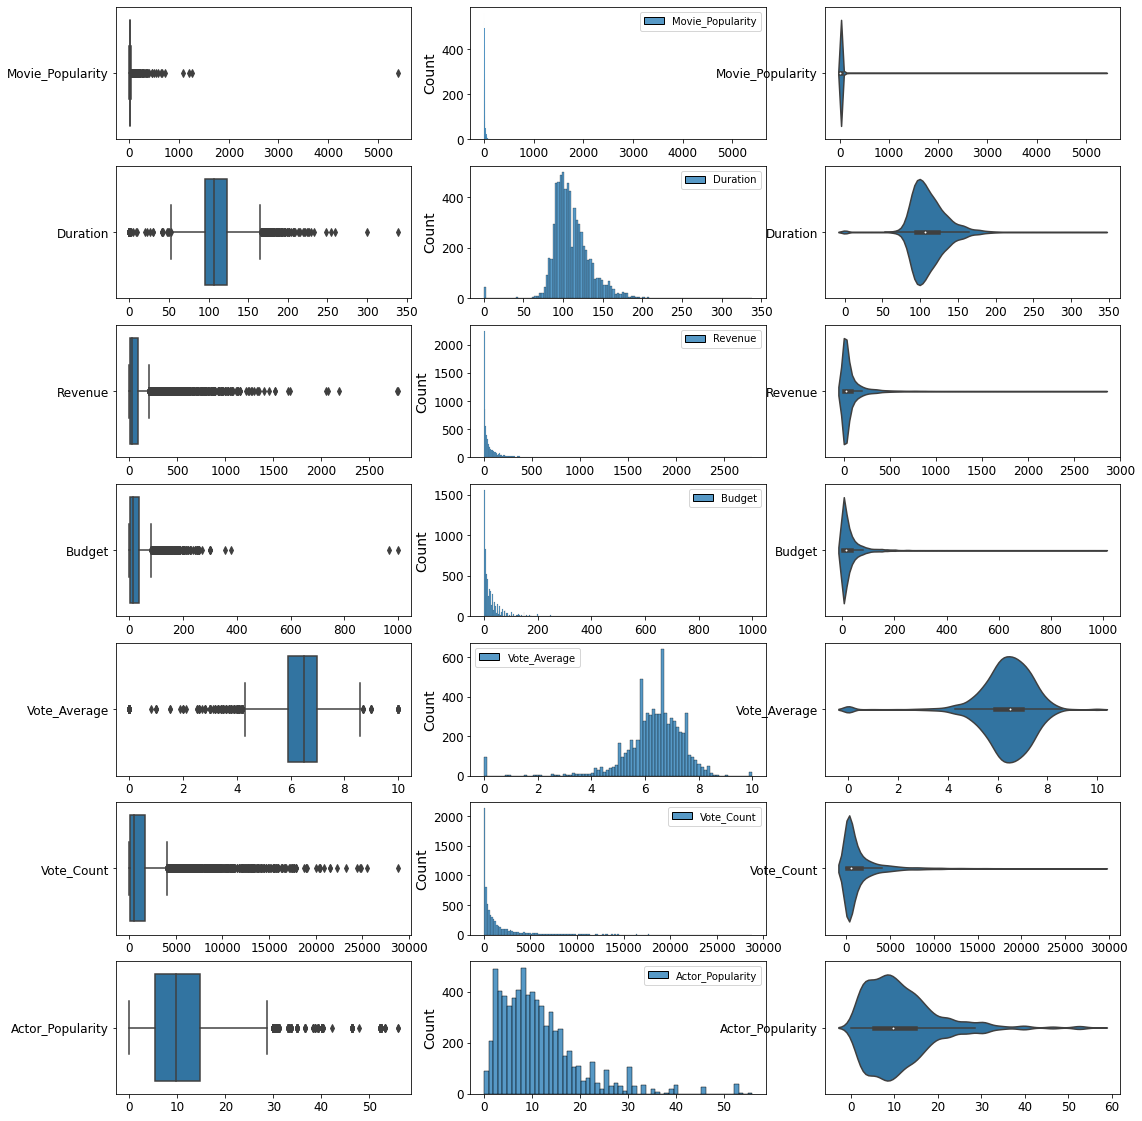

In [ ]:
# Draw the distributions of all variables
f, axes = plt.subplots(7, 3, figsize=(18, 20))
count = 0
for var in numeric_rows.columns:
    col_data = pd.DataFrame(numeric_rows[var])
    sns.boxplot(data = col_data, orient = "h", ax = axes[count,0])
    sns.histplot(data = col_data, ax = axes[count,1])
    sns.violinplot(data = col_data, orient = "h", ax = axes[count,2])
    count += 1
    

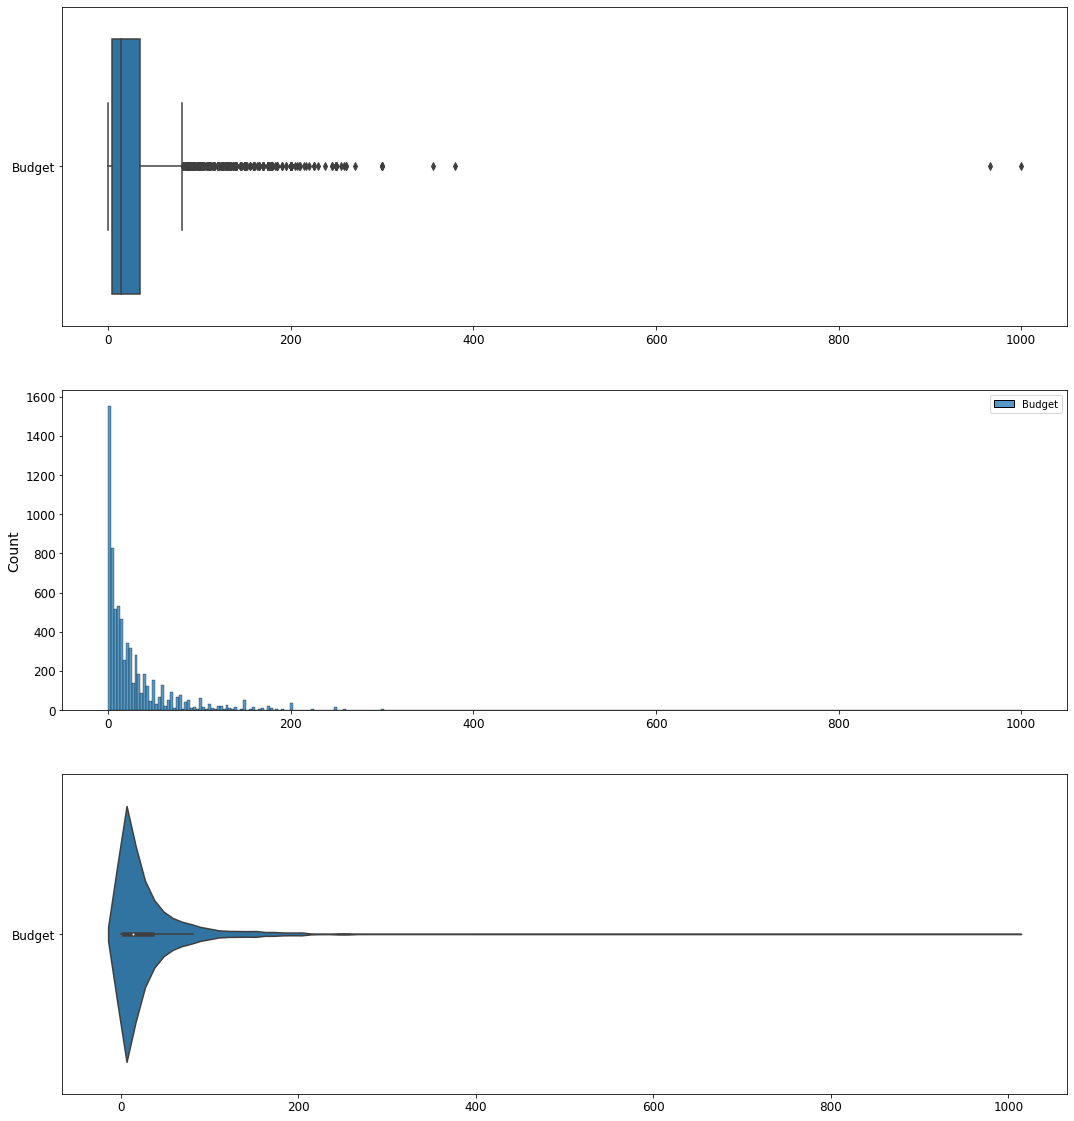

In [ ]:
# Close up distribution of budget
f, axes = plt.subplots(3, 1, figsize=(18, 20))
sns.boxplot(data = budget, orient = "h", ax = axes[0])
sns.histplot(data = budget, ax = axes[1])
sns.violinplot(data = budget, orient = "h", ax = axes[2])


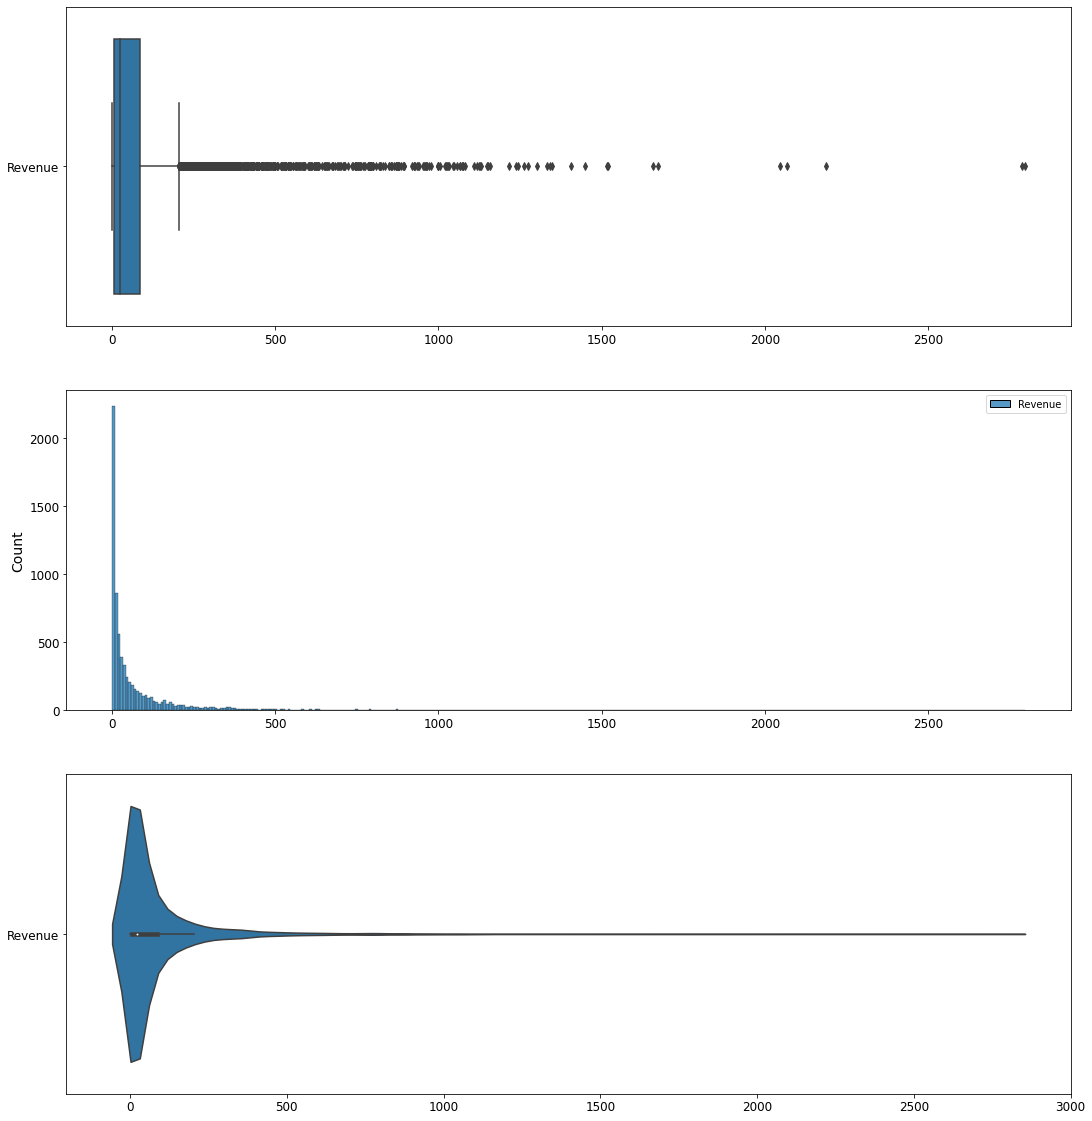

In [ ]:
# CLose up distribution of Revenue
f, axes = plt.subplots(3, 1, figsize=(18, 20))
sns.boxplot(data = revenue, orient = "h", ax = axes[0])
sns.histplot(data = revenue, ax = axes[1])
sns.violinplot(data = revenue, orient = "h", ax = axes[2])


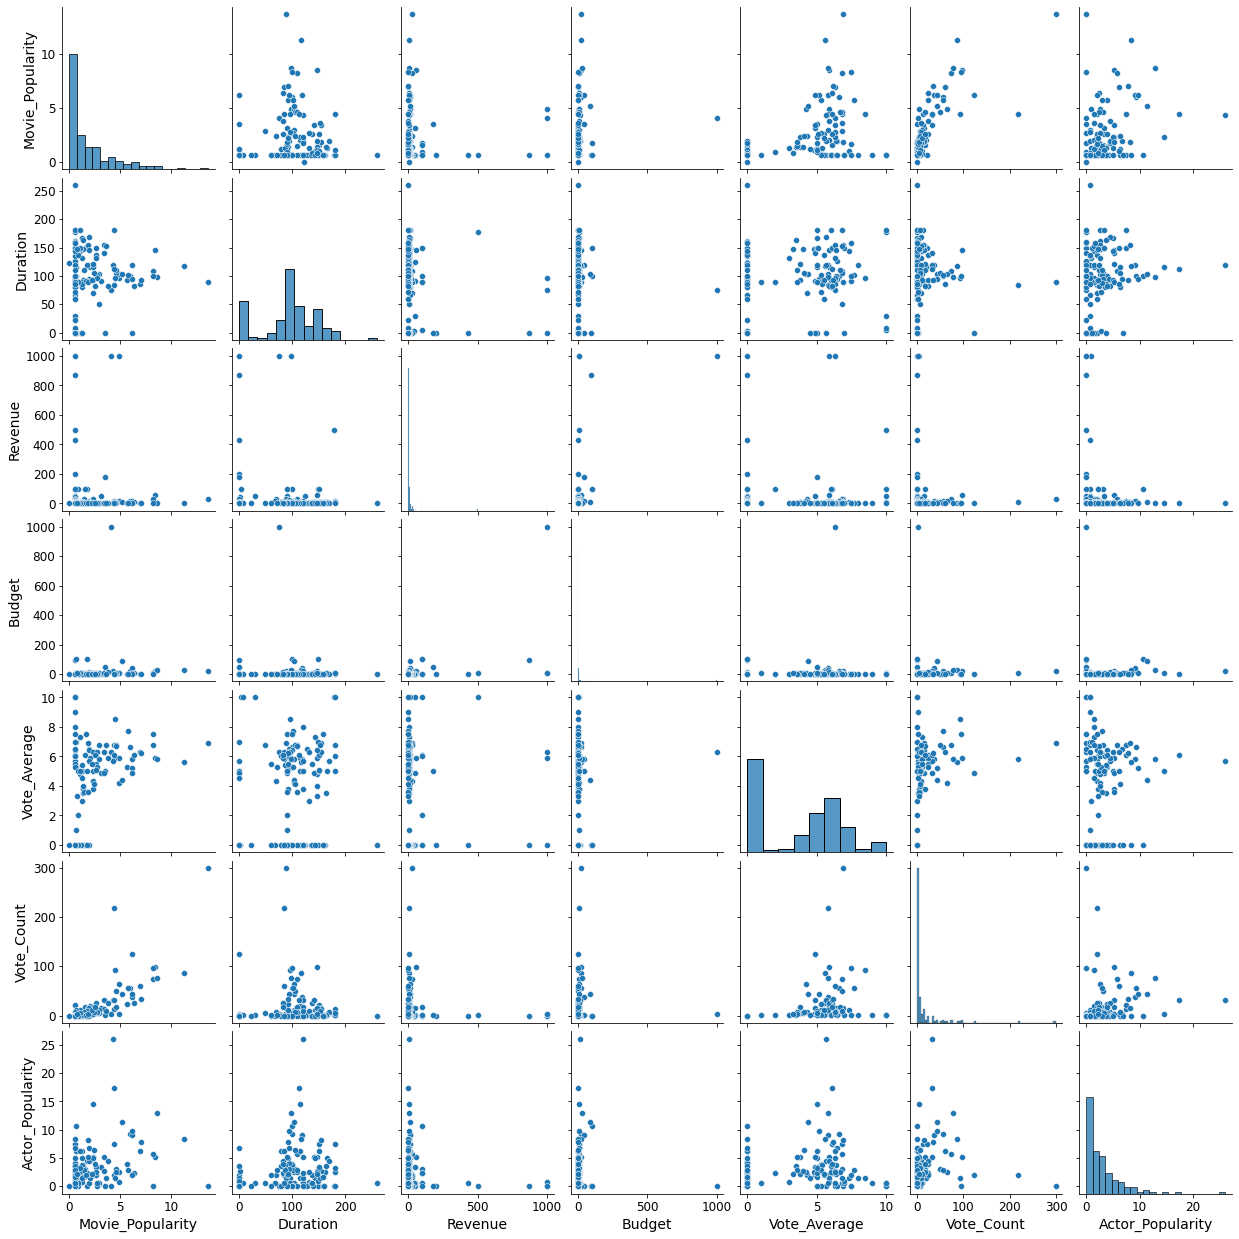

In [ ]:
# Draw pairs of variables against one another
sns.pairplot(data = numeric_rows)

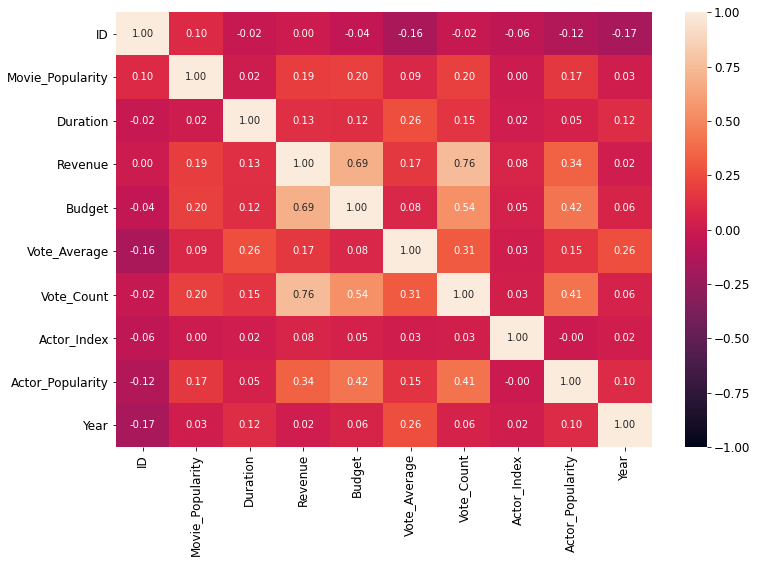

In [ ]:
f = plt.figure(figsize=(12, 8))
sns.heatmap(complete_data.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

In [ ]:
#Correlation of all variables with Revenue alone

corr_matrix = complete_data.corr()
corr_matrix["Revenue"].sort_values(ascending=False)

# 'Vote_Count', 'Budget' and 'Actor_Popularity' are the topmost correlated attributes with the target, 'Revenue'

Revenue             1.000000
Vote_Count          0.756105
Budget              0.693358
Actor_Popularity    0.340591
Movie_Popularity    0.191150
Vote_Average        0.170997
Duration            0.131857
Actor_Index         0.076272
Year                0.019889
ID                  0.000912
Name: Revenue, dtype: float64

**It is also useful to observe correlations with the highest correlated variable**

Variables that are very high correlated to the highest correlated variable may not be useful as very little independence. Does not give much information since both variables will give same direction to Revenue. (Especially in decision trees and Random Forest)

In [ ]:
# Getting the standard correlation coefficient (Pearson Correlation) between every attributes with attribute
corr_matrix["Vote_Count"].sort_values(ascending=False)

# 'Revenue', 'Budget', 'Actor_Popularity' and 'Vote_Average' are the topmost correlated attributes with the attribute, 'Vote_Count'

Vote_Count          1.000000
Revenue             0.756105
Budget              0.544159
Actor_Popularity    0.406557
Vote_Average        0.308490
Movie_Popularity    0.195733
Duration            0.149520
Year                0.056829
Actor_Index         0.033379
ID                 -0.019375
Name: Vote_Count, dtype: float64

**Observations**

Based on correlation **Vote_Count, Budget and Actor Popularity** have pretty good correlation with **Revenue**

We exclude values with correlation of below 0.10 and below as too low to have any significant impact.

However, low correlations that are above 0.10 are still included such as **Movie_Popularity, Duration, Vote_Average** as they might still have an impact on revenue. Hence we included them as predictors/features.

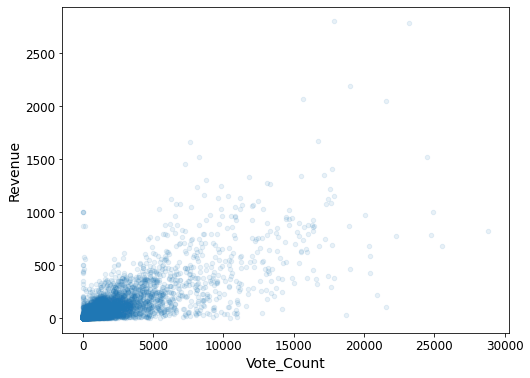

In [ ]:
complete_data.plot(kind="scatter", x="Vote_Count", y="Revenue", figsize=(8, 6), alpha=0.1)

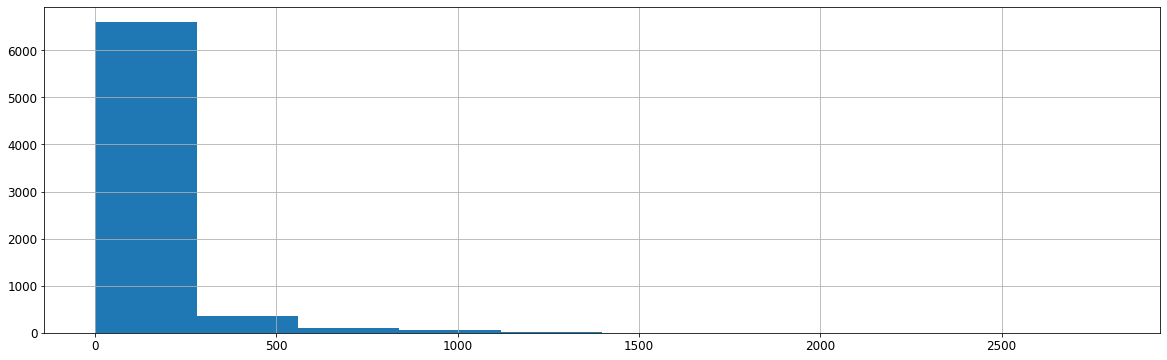

In [ ]:
complete_data['Revenue'].hist(figsize=(20,6))

[Text(0, 0.5, 'Revenue (millions)'),
 Text(0.5, 0, 'Budget (millions)'),
 Text(0.5, 1.0, 'American Films with Highest Revenue')]

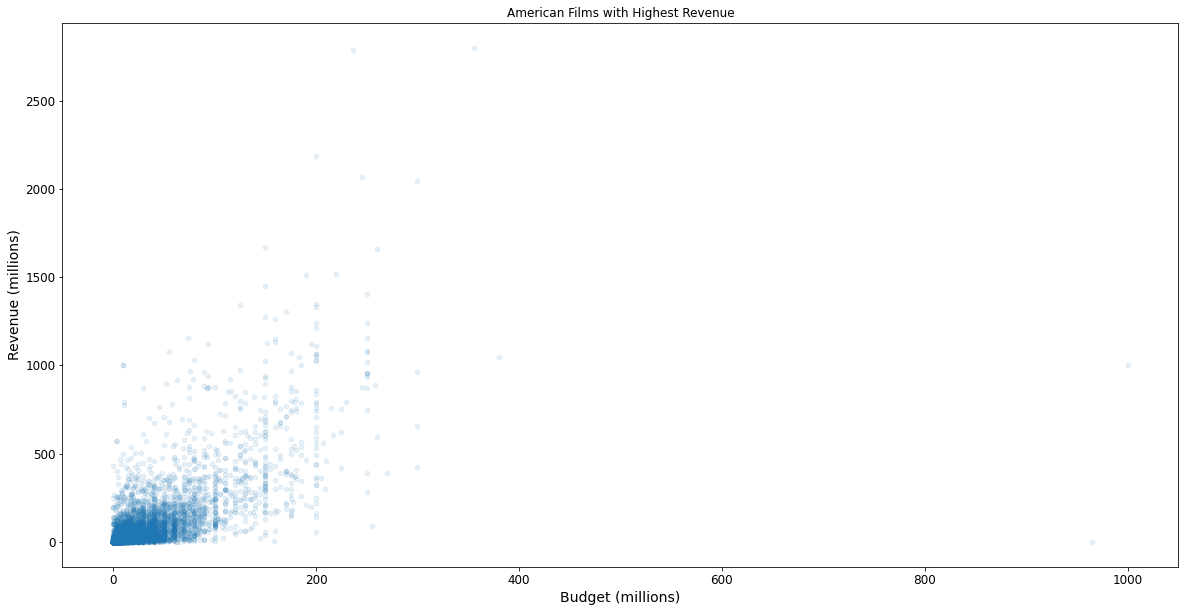

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))

complete_data.plot(kind="scatter", x="Budget", y="Revenue", alpha=0.1, ax=ax)
ax.set(title='American Films with Highest Revenue', xlabel='Budget (millions)', ylabel='Revenue (millions)')

[Text(0, 0.5, 'Revenue (millions)'),
 Text(0.5, 0, 'Duration (mins)'),
 Text(0.5, 1.0, 'American Films with Highest Revenue')]

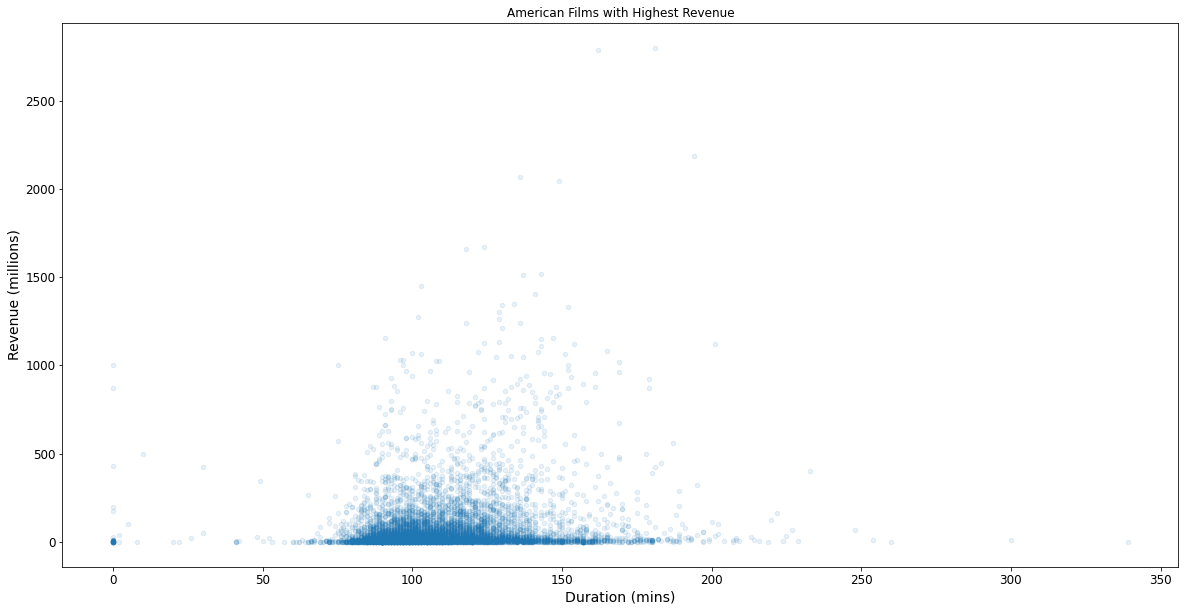

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))

complete_data.plot(kind="scatter", x="Duration", y="Revenue", alpha=0.1, ax=ax)
ax.set(title='American Films with Highest Revenue', xlabel='Duration (mins)', ylabel='Revenue (millions)')

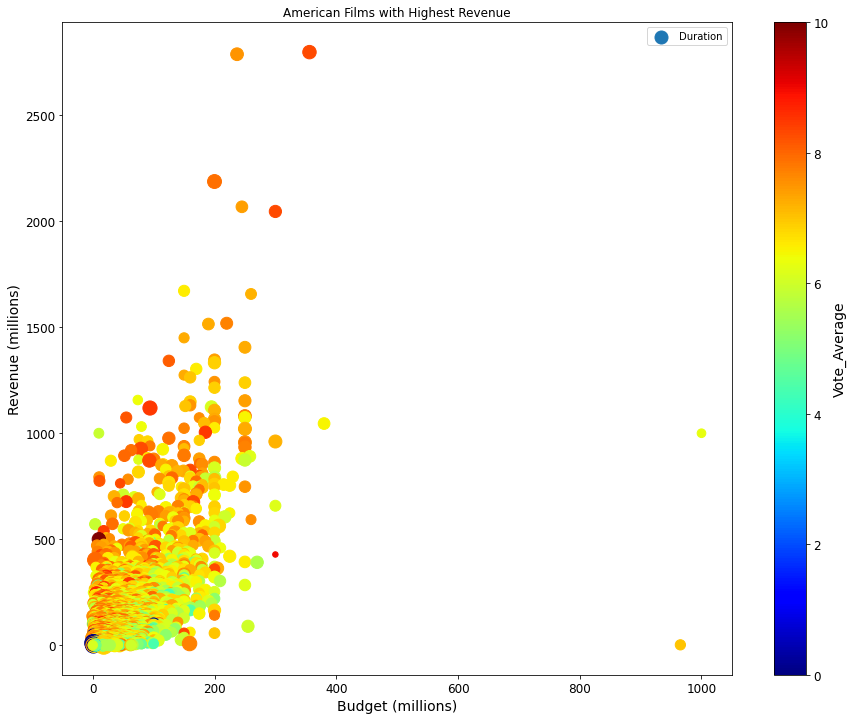

In [ ]:
fig, ax = plt.subplots(figsize=(15,12))

# s (size) represents the 'Duration and  c (color) represents the 'Vote Average'
complete_data.plot(kind="scatter", x="Budget", y="Revenue", alpha=1.0,
                              s= "Duration", label="Duration", ax=ax,
                              c= "Vote_Average", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)

ax.set(title='American Films with Highest Revenue', xlabel='Budget (millions)', ylabel='Revenue (millions)')
plt.legend()

**Observations**

**Color** represents Vote_Average
**Size** represents Duration

Generally Budget has a positive correlation relationship with Revenue, moreover the duration and vote average also seems to be higher. The colors are darker and bubble size is larger.

Even though correlation of Vote_Average with Revenue is only **0.3**, it generally becomes a darker color (Higher) as Revenue and Budget increases

### Filling up of missing values

We will remove columns: **'ID', 'Film', 'Release Date', 'Actor_Index', 'Most_Popular_Actor', 'Year'**

Hence:

Predictors/ Features: **Movie_Popularity, Duration, Budget(Millions), Production_Country, Vote_Average, Vote_Count, Actor_Popularity**

**Note** Production_Country is later replaced by Production_Country_Cat which is regions

Response variable: **Revenue(Millions)**


In [ ]:
partial_dataset = complete_data.drop(columns = ['ID', 'Film', 'Release_Date', 'Actor_Index', 'Most_Popular_Actor', 'Year'])
partial_dataset.head()

,Movie_Popularity,Duration,Revenue,Budget,Production_Country,Vote_Average,Vote_Count,Actor_Popularity
0,282.089,181.0,2797.800564,356.0,United States of America,8.3,17867,52.500
1,97.637,162.0,2787.965087,237.0,United States of America,7.5,23220,14.225
2,84.213,194.0,2187.463944,200.0,United States of America,7.9,19028,19.043
3,58.173,136.0,2068.223624,245.0,United States of America,7.4,15701,19.421
4,273.582,149.0,2046.239637,300.0,United States of America,8.3,21548,52.334


In [ ]:
partial_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7129 entries, 0 to 7128
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Movie_Popularity    7129 non-null   float64
 1   Duration            7126 non-null   float64
 2   Revenue             7129 non-null   float64
 3   Budget              7129 non-null   float64
 4   Production_Country  6994 non-null   object 
 5   Vote_Average        7129 non-null   float64
 6   Vote_Count          7129 non-null   int64  
 7   Actor_Popularity    7129 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 445.7+ KB


Fill up missing values for **Production_Country**

In [ ]:
# Check for missing values in Production Country
partial_dataset['Production_Country'].isnull().sum()

135

In [ ]:
# Replace missing value, NaN, with default value 'Others'
partial_dataset['Production_Country'] = partial_dataset['Production_Country'].replace(np.nan, 'Others')
partial_dataset['Production_Country'].isnull().sum()

0

In [ ]:
#Checking for countries with others
partial_dataset.loc[partial_dataset['Production_Country'] == 'Others']

,Movie_Popularity,Duration,Revenue,Budget,Production_Country,Vote_Average,Vote_Count,Actor_Popularity
43,0.600,0.0,1000.000000,10.000000,Others,0.0,0,0.000
44,4.873,97.0,1000.000000,10.000000,Others,5.9,4,0.838
45,4.078,75.0,999.999999,999.999999,Others,6.3,3,0.000
71,0.600,0.0,871.530324,93.000000,Others,0.0,0,0.000
212,0.600,178.0,500.000000,10.000000,Others,10.0,1,0.000
...,...,...,...,...,...,...,...,...
7073,0.600,158.0,0.408198,0.204099,Others,0.0,0,1.586
7080,0.600,85.0,0.400000,0.250000,Others,0.0,0,0.600
7109,0.600,143.0,0.361618,0.578861,Others,0.0,0,5.029
7122,0.780,147.0,0.350000,4.200000,Others,3.3,4,2.191


### Transforming of production countries to regions

In [ ]:
# List unique values
print("No. of unique production countries :", partial_dataset.Production_Country.nunique())
print("and they are namely :")
partial_dataset.Production_Country.unique()

No. of unique production countries : 80
and they are namely :


array(['United States of America', 'United Kingdom', 'Australia',
       'New Zealand', 'Canada', 'Others', 'China', 'Germany',
       'United Arab Emirates', 'Monaco', 'Japan', 'France', 'Hong Kong',
       'Czech Republic', 'Morocco', 'Italy', 'Finland', 'Belgium',
       'Denmark', 'India', 'Spain', 'Mexico', 'South Korea', 'Hungary',
       'Bulgaria', 'Ireland', 'Iceland', 'Netherlands', 'Peru', 'Uruguay',
       'Brazil', 'Russia', 'Austria', 'Colombia', 'Romania',
       'South Africa', 'Sweden', 'Indonesia', 'Pakistan', 'Afghanistan',
       'Singapore', 'Lebanon', 'Switzerland', 'Argentina', 'Tanzania',
       'Taiwan', 'Turkey', 'Thailand', 'Chile', 'Iran', 'Poland',
       'Algeria', 'Israel', 'Greece', 'Bahamas', 'Luxembourg', 'Egypt',
       'Kuwait', 'Norway', 'Ecuador', 'Philippines', 'Ukraine', 'Ghana',
       'Vietnam', 'Venezuela', 'Belarus', 'Namibia', 'Malaysia',
       'Palestinian Territory', 'Burkina Faso', 'Bangladesh', 'Estonia',
       'Libyan Arab Jamahiriya'

In [ ]:
#Pick 23 countries with largest no.
partial_dataset.Production_Country.value_counts().nlargest(24)

United States of America    4005
India                        499
United Kingdom               468
France                       288
Canada                       255
Germany                      227
Russia                       148
Others                       135
Australia                    120
Japan                        107
Spain                         95
China                         91
Italy                         77
South Korea                   62
Belgium                       54
Hong Kong                     36
Ireland                       28
Denmark                       28
Mexico                        26
Czech Republic                26
Argentina                     22
Brazil                        22
New Zealand                   19
Turkey                        19
Name: Production_Country, dtype: int64

In [ ]:
top1_ctr = 0
top2_ctr = 0
top3_ctr = 0
top4_ctr = 0
others_ctr = 0
production_country_category = []

# Create top 5 categories
for ctry in partial_dataset['Production_Country']:
    #print(ctry)
    if ctry == 'United States of America' or ctry == 'Canada' or ctry == 'Mexico' or \
       ctry == 'Argentina' or ctry == 'Brazil':
      # production_country_cat.loc[len(production_country_cat)]=[ctry, 1]
      production_country_category.append('America')
      top1_ctr += 1
    elif ctry == 'United Kingdom' or ctry == 'France' or ctry == 'Germany' or ctry == 'Russia' or \
         ctry == 'Spain' or ctry == 'Italy' or ctry == 'Belgium' or ctry == 'Ireland' or \
         ctry == 'Denmark' or ctry == 'Czech Republic' or ctry == 'Turkey':
      production_country_category.append('Europe')
      top2_ctr += 1
    elif ctry == 'India' or ctry == 'Japan' or ctry == 'China' or ctry == 'South Korea' or ctry == 'Hong Kong':
      production_country_category.append('Asia')
      top3_ctr += 1
    elif ctry == 'Australia' or ctry == 'New Zealand':
      production_country_category.append('Oceania')
      top4_ctr += 1
    else:
      production_country_category.append('Others')
      others_ctr += 1

partial_dataset['Production_Country_Category'] = production_country_category

# len(complete_data) - top1_ctr - top2_ctr - top3_ctr - top4_ctr
top1_ctr, top2_ctr, top3_ctr, top4_ctr, others_ctr

(4330, 1458, 795, 139, 407)

In [ ]:
# Verifications
regions = ['America', 'Europe', 'Asia', 'Oceania', 'Others']
for region in regions:
    print('Region {} with count : {}'.format(region, (partial_dataset['Production_Country_Category'] == region).sum()))

Region America with count : 4330
Region Europe with count : 1458
Region Asia with count : 795
Region Oceania with count : 139
Region Others with count : 407


**Putting regions into a column**

In [ ]:
# define column names for our new dataframe
columns = ['Production_Country_Category', 'Total_Number']

# create dataframe with film and revenue columns
production_country_cat = pd.DataFrame(columns=columns)

production_country_cat.loc[len(production_country_cat)]=['America', top1_ctr]
production_country_cat.loc[len(production_country_cat)]=['Europe', top2_ctr]
production_country_cat.loc[len(production_country_cat)]=['Asia', top3_ctr]
production_country_cat.loc[len(production_country_cat)]=['Oceania', top4_ctr]
production_country_cat.loc[len(production_country_cat)]=['Others', others_ctr]

production_country_cat

,Production_Country_Category,Total_Number
0,America,4330
1,Europe,1458
2,Asia,795
3,Oceania,139
4,Others,407


In [ ]:
partial_dataset

,Movie_Popularity,Duration,Revenue,Budget,Production_Country,Vote_Average,Vote_Count,Actor_Popularity,Production_Country_Category
0,282.089,181.0,2797.800564,356.000,United States of America,8.3,17867,52.500,America
1,97.637,162.0,2787.965087,237.000,United States of America,7.5,23220,14.225,America
2,84.213,194.0,2187.463944,200.000,United States of America,7.9,19028,19.043,America
3,58.173,136.0,2068.223624,245.000,United States of America,7.4,15701,19.421,America
4,273.582,149.0,2046.239637,300.000,United States of America,8.3,21548,52.334,America
...,...,...,...,...,...,...,...,...,...
7124,9.001,97.0,0.346592,5.000,United States of America,6.1,214,18.096,America
7125,2.381,104.0,0.345000,0.145,Turkey,7.4,16,1.960,Europe
7126,8.112,127.0,0.343617,2.000,Romania,6.7,183,2.038,Others
7127,3.277,113.0,0.340312,5.000,Russia,4.9,16,2.464,Europe


In [ ]:
def plot_topmost_parm(source_df, col_name, total_items, display_topmost, text_padding):
    col_Grp = pd.DataFrame()
    col_Grp['grpCount'] = source_df.groupby([col_name])[col_name].count()
    col_Grp[col_name] = col_Grp.index

    # There are too many for USA, so we will subset the top group
    col_grp_top = col_Grp.sort_values(by='grpCount',ascending=False).head(display_topmost)
    order_grp = col_grp_top.sort_values(by='grpCount',ascending=False)[col_name]

    plt.figure(figsize=(25, 10))
    sns.set(color_codes=True)
    sns.set(font_scale = 1.3)
    ax = sns.barplot(x=col_name, y='grpCount', data=col_grp_top, order=order_grp)
    ax.set_title("Top " + str(display_topmost) + " ranking of " + col_name, fontsize=18)
    for rectBox in ax.patches:
        count = rectBox.get_height()
        #print("Counts :", count)    
        ax.text(rectBox.get_x() + rectBox.get_width()/2.,
                count + text_padding,
                '{:1.2f}%'.format(count/total_items*100),
                ha="center", fontsize=11)

    xt = plt.xticks(rotation=60)
    plt.show()

    print("Total no. of " + col_name + " :", len(col_Grp.index))
    print("Missing Data for " + col_name + " : " +
          '{:1.2f}%'.format(source_df[col_name].isnull().sum() / total_items * 100))
    #print("Top " + str(display_topmost) + " :\n", col_grp_top[col_name])

    for ctr in range(len(col_grp_top)):
        if (col_grp_top.iloc[ctr][col_name] == -999):
            print("Found in Index", str(ctr) + " :", col_grp_top.iloc[ctr]['grpCount'])
            print("Missing Data : " + '{:1.2f}%'.format(col_grp_top.iloc[ctr]['grpCount'] / total_items * 100))

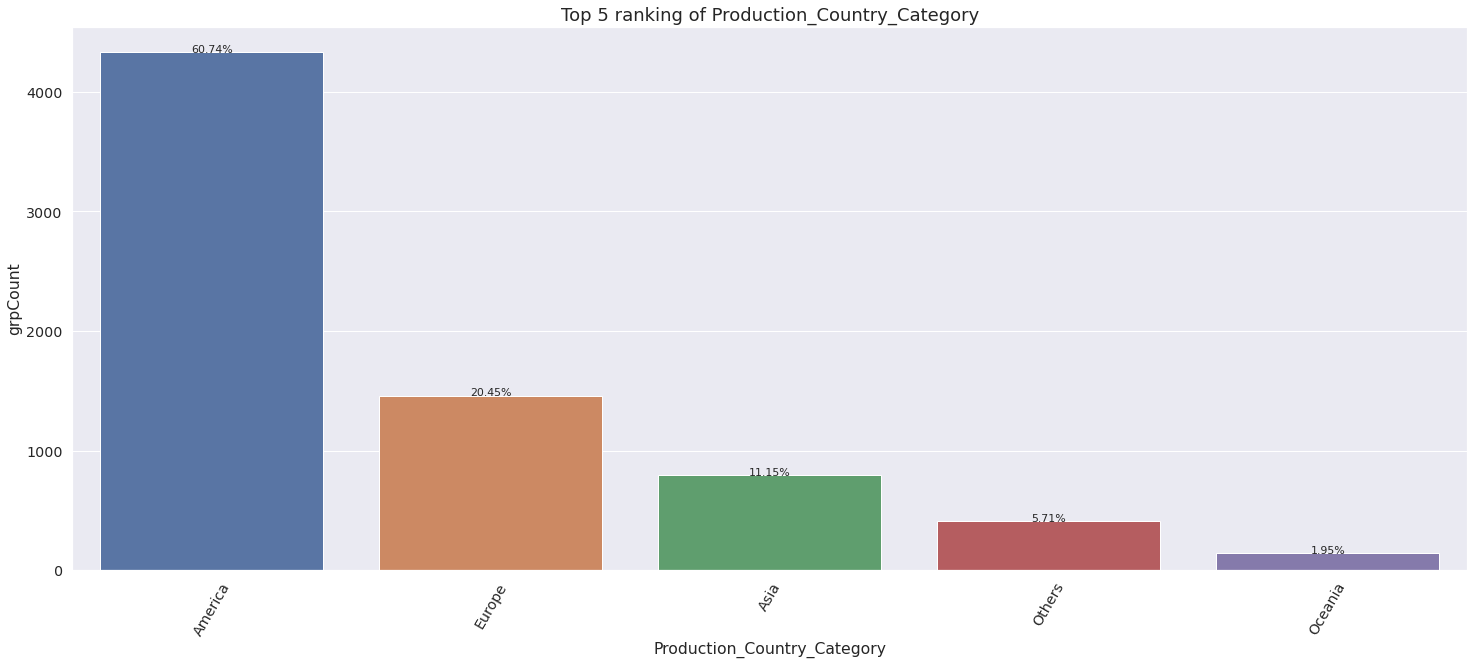

Total no. of Production_Country_Category : 5
Missing Data for Production_Country_Category : 0.00%


In [ ]:
# Plot Production_Country details
plot_topmost_parm(source_df=partial_dataset, col_name='Production_Country_Category', total_items=len(partial_dataset), display_topmost=5, text_padding = 0.1)

In [ ]:
#Remove production country as no longer needed
partial_dataset = partial_dataset.drop(columns = ['Production_Country'])
partial_dataset.head()

,Movie_Popularity,Duration,Revenue,Budget,Vote_Average,Vote_Count,Actor_Popularity,Production_Country_Category
0,282.089,181.0,2797.800564,356.0,8.3,17867,52.500,America
1,97.637,162.0,2787.965087,237.0,7.5,23220,14.225,America
2,84.213,194.0,2187.463944,200.0,7.9,19028,19.043,America
3,58.173,136.0,2068.223624,245.0,7.4,15701,19.421,America
4,273.582,149.0,2046.239637,300.0,8.3,21548,52.334,America


Recommendations:

Could replace each category with a learnable, low-dimensional vector called an embedding.

Each category’s representation would be learned during training with representation learning.
Could explore with other Machine Learning models (eg. Support Vectore Machine, Neural Network) to observe if the performance metric (ie. accuracy) can be improved.

### Replacing of 0 with medians for selected features

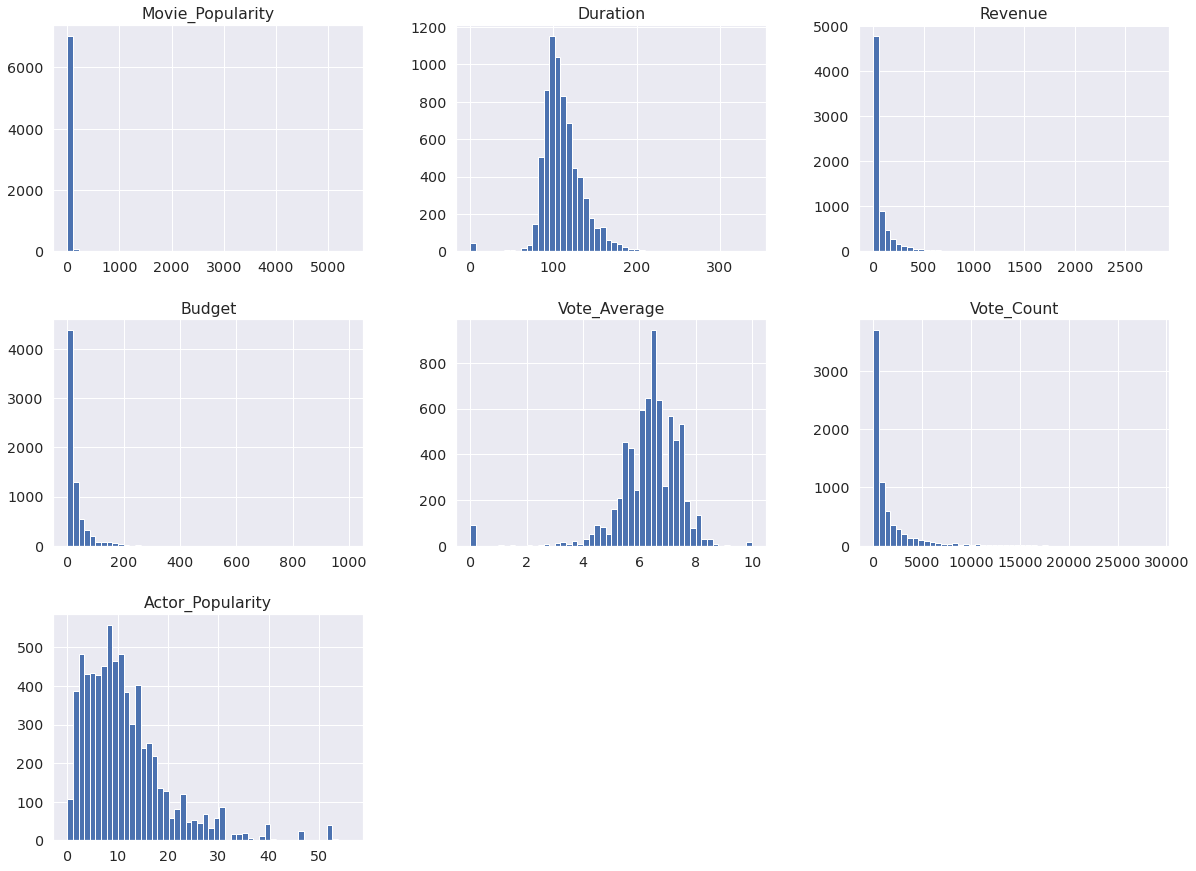

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
partial_dataset.hist(bins=50, figsize=(20,15))
#save_fig("attribute_histogram_plots")

plt.show()

**Before replacing 0s with median**

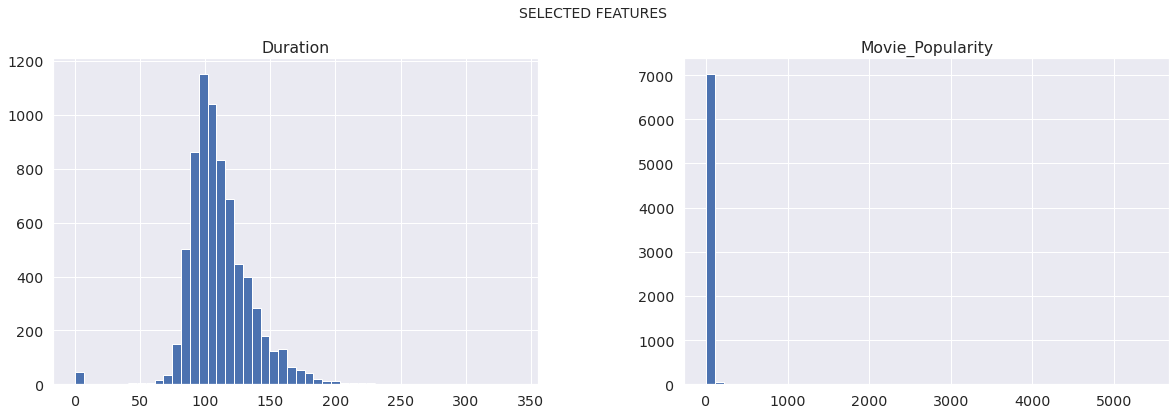

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
fig.suptitle('Selected Features'.upper(), y=1.0, fontsize=14)

# Left histogram
axes[0].set_title('Duration')
partial_dataset['Duration'].hist(bins=50, ax=axes[0])

# Right histogram
axes[1].set_title('Movie_Popularity')
partial_dataset.hist('Movie_Popularity', bins=50, ax=axes[1])

plt.show()

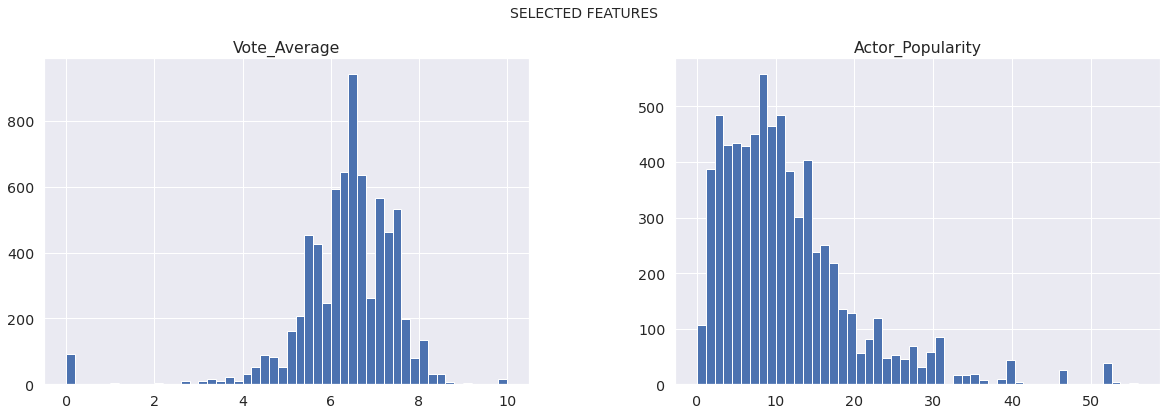

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
fig.suptitle('Selected Features'.upper(), y=1.0, fontsize=14)

# Left histogram
axes[0].set_title('Vote_Average')
partial_dataset['Vote_Average'].hist(bins=50, ax=axes[0])

# Right histogram
axes[1].set_title('Actor_Popularity')
partial_dataset.hist('Actor_Popularity', bins=50, ax=axes[1])

plt.show()

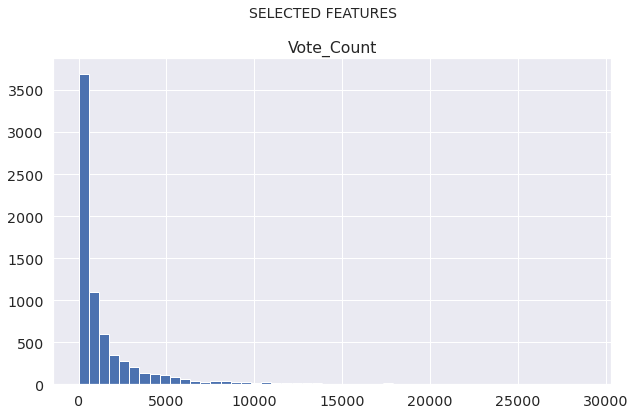

In [ ]:
fig, axes = plt.subplots(figsize=(10, 6))
fig.suptitle('Selected Features'.upper(), y=1.0, fontsize=14)

# Left histogram
axes.set_title('Vote_Count')
partial_dataset['Vote_Count'].hist(bins=50)

plt.show()

** Transforming 0s to median values**

We only pick duration and vote_count to transform 0 values to median as the 0 values are outliers.

Median is chosen as average is affected by outliers and median serves as a better estimate.

In [ ]:
# Note : Store the median values so that they can be used to replace missing values in the test set when you want to evaluate your system,
# and also once the system goes live to replace missing values in new data.
median_dict = {}
median_dict['Duration'] = partial_dataset['Duration'].median()
median_dict['Movie_Popularity'] = partial_dataset['Movie_Popularity'].median()
median_dict['Vote_Average'] = partial_dataset['Vote_Average'].median()
median_dict['Actor_Popularity'] = partial_dataset['Actor_Popularity'].median()
median_dict['Vote_Count'] = partial_dataset['Vote_Count'].median()

print('The stored median dictionary :\n', median_dict)



The stored median dictionary :
 {'Duration': 107.0, 'Movie_Popularity': 13.091, 'Vote_Average': 6.5, 'Actor_Popularity': 9.642999999999999, 'Vote_Count': 527.0}


In [ ]:
# Before transformation no. of data with median values
print("\nBefore transformation (median values) :")
print("---------------------------------------")
print("No. of Duration with median ({}) : {}".\
      format(partial_dataset['Duration'].median(), (partial_dataset['Duration'] == partial_dataset['Duration'].median()).sum()))
print("No. of Movie_Popularity with median ({}) : {}".\
       format(partial_dataset['Movie_Popularity'].median(), (partial_dataset['Movie_Popularity'] == partial_dataset['Movie_Popularity'].median()).sum()))
print("No. of Vote_Average with median ({}) : {}".\
      format(partial_dataset['Vote_Average'].median(), (partial_dataset['Vote_Average'] == partial_dataset['Vote_Average'].median()).sum()))
print("No. of Actor_Popularity with median ({}) : {}".\
      format(partial_dataset['Actor_Popularity'].median(), (partial_dataset['Actor_Popularity'] == partial_dataset['Actor_Popularity'].median()).sum()))
print("No. of Vote_Count with median ({}) : {}".\
      format(partial_dataset['Vote_Count'].median(), (partial_dataset['Vote_Count'] == partial_dataset['Vote_Count'].median()).sum()))



Before transformation (median values) :
---------------------------------------
No. of Duration with median (107.0) : 140
No. of Movie_Popularity with median (13.091) : 2
No. of Vote_Average with median (6.5) : 312
No. of Actor_Popularity with median (9.642999999999999) : 4
No. of Vote_Count with median (527.0) : 3


**Based on domain knowledge, hist plots and previous no.s we can tell how many values are approximately median. Hence those with 0 as outliers should be changed to median**.

Changing to median instead of average as average is affected by outliers and median would provide a better estimate


In [ ]:
# Replace zero values with median
partial_dataset['Duration'] = partial_dataset['Duration'].replace(0, partial_dataset['Duration'].median())
partial_dataset['Vote_Average'] = partial_dataset['Vote_Average'].replace(0, partial_dataset['Vote_Average'].median())


print("\nAfter transformation (median values) :")
print("----------------------------------------")
print("No. of Duration with median ({}) : {}".\
      format(partial_dataset['Duration'].median(), (partial_dataset['Duration'] == partial_dataset['Duration'].median()).sum()))
print("No. of Vote_Average with median ({}) : {}".\
      format(partial_dataset['Vote_Average'].median(), (partial_dataset['Vote_Average'] == partial_dataset['Vote_Average'].median()).sum()))

# Note : The minimum values are no longer zero
print("\nNew statistics after transformation :")
print("-------------------------------------")
partial_dataset.Duration.describe(), partial_dataset.Vote_Average.describe()


After transformation (median values) :
----------------------------------------
No. of Duration with median (107.0) : 183
No. of Vote_Average with median (6.5) : 404

New statistics after transformation :
-------------------------------------


(count    7126.000000
 mean      111.305080
 std        22.952744
 min         2.000000
 25%        96.000000
 50%       107.000000
 75%       123.000000
 max       339.000000
 Name: Duration, dtype: float64, count    7129.000000
 mean        6.425712
 std         0.931481
 min         0.800000
 25%         5.900000
 50%         6.500000
 75%         7.000000
 max        10.000000
 Name: Vote_Average, dtype: float64)

**After changing appropriate values to 0**

Only thing left is to use imputer for missing values

In [ ]:
numeric_feature_count = 0
non_numeric_feature_count = 0

for col in partial_dataset.columns:
  if (partial_dataset[col].dtypes == 'int64') or (partial_dataset[col].dtypes == 'float64'):
    numeric_feature_count += 1
    print("Numeric feature No. {} and name : {}".format(numeric_feature_count, col))
    print("No. of Missing values : {}, Zero values : {}, Median values : {}".\
      format(partial_dataset[col].isnull().sum(), (partial_dataset[col] == 0).sum(),
             (partial_dataset[col] == partial_dataset[col].median()).sum()))
    print("-" * 70)
    print()
  else:
    non_numeric_feature_count += 1
    print("Non-numeric feature No. {} and name : {}".format(non_numeric_feature_count, col))
    print("No. of Missing values : {}, Zero values : {}".\
      format(partial_dataset[col].isnull().sum(), (partial_dataset[col] == 0).sum()))
    print("-" * 50)
    print()

print("Total No. of Numeric features {} and Non-numeric features : {}".format(numeric_feature_count, non_numeric_feature_count))

Numeric feature No. 1 and name : Movie_Popularity
No. of Missing values : 0, Zero values : 1, Median values : 2
----------------------------------------------------------------------

Numeric feature No. 2 and name : Duration
No. of Missing values : 3, Zero values : 0, Median values : 183
----------------------------------------------------------------------

Numeric feature No. 3 and name : Revenue
No. of Missing values : 0, Zero values : 0, Median values : 1
----------------------------------------------------------------------

Numeric feature No. 4 and name : Budget
No. of Missing values : 0, Zero values : 0, Median values : 73
----------------------------------------------------------------------

Numeric feature No. 5 and name : Vote_Average
No. of Missing values : 0, Zero values : 0, Median values : 404
----------------------------------------------------------------------

Numeric feature No. 6 and name : Vote_Count
No. of Missing values : 0, Zero values : 92, Median values : 3

**Only left with duration with null values which will be imputed later in pipeline**

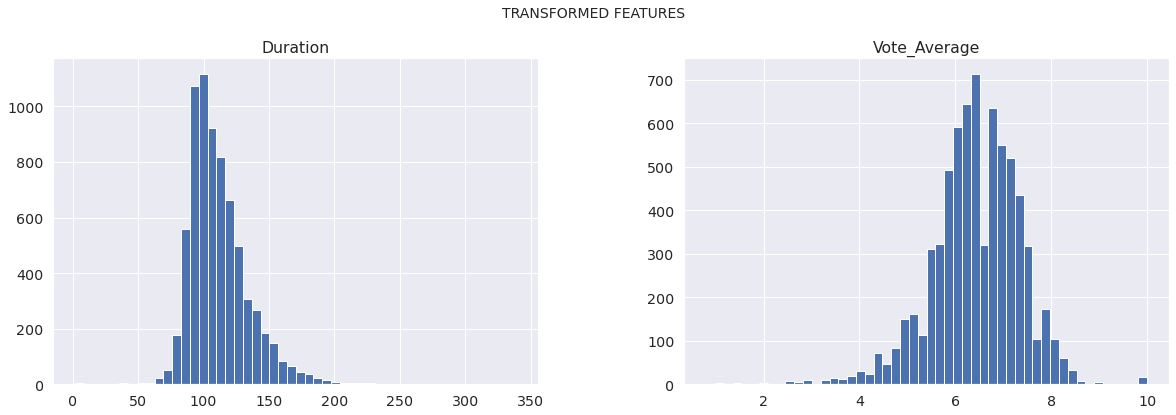

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
fig.suptitle('Transformed Features'.upper(), y=1.0, fontsize=14)

# Left histogram
axes[0].set_title('Duration')
partial_dataset['Duration'].hist(bins=50, ax=axes[0])

# Right histogram
axes[1].set_title('Vote_Average')
partial_dataset.hist('Vote_Average', bins=50, ax=axes[1])

plt.show()

## Section 3: Data Preprocessing
1. Use of simple imputer (For filling of missing values with median)
2. Use of one hot encoding for categorical variables (Production Countries)
3. Use of **standard scaler**
Standard scaler helps as most values are already gaussian and would scale all features to the same scale for greater accuracy

**Standard scaler helps scale Budget in millions and vote count in 1000s to same scale for greater accuracy**

In [ ]:
#Imports for preprocessing

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

#Imports for Linear Regression model:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#Imports for Decison Tree Regressor model:
from sklearn.tree import DecisionTreeRegressor

#Imports for Random Forest Regressor model:
from sklearn.ensemble import RandomForestRegressor

#Imports for SVM:
from sklearn.svm import SVR

#Imports for display of Decision Tree
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.metrics import r2_score
from IPython.display import SVG
from graphviz import Source
from IPython.display import display


In [ ]:
numeric_data = partial_dataset.drop(columns = ['Production_Country_Category'])

numeric_data.head()

,Movie_Popularity,Duration,Revenue,Budget,Vote_Average,Vote_Count,Actor_Popularity
0,282.089,181.0,2797.800564,356.0,8.3,17867,52.500
1,97.637,162.0,2787.965087,237.0,7.5,23220,14.225
2,84.213,194.0,2187.463944,200.0,7.9,19028,19.043
3,58.173,136.0,2068.223624,245.0,7.4,15701,19.421
4,273.582,149.0,2046.239637,300.0,8.3,21548,52.334


In [ ]:
numeric_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7129 entries, 0 to 7128
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Movie_Popularity  7129 non-null   float64
 1   Duration          7126 non-null   float64
 2   Revenue           7129 non-null   float64
 3   Budget            7129 non-null   float64
 4   Vote_Average      7129 non-null   float64
 5   Vote_Count        7129 non-null   int64  
 6   Actor_Popularity  7129 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 390.0 KB


### Testing out imputer

In [ ]:
imputer = SimpleImputer(strategy="median")

In [ ]:
imputer.fit(numeric_data)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [ ]:
numeric_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7129 entries, 0 to 7128
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Movie_Popularity  7129 non-null   float64
 1   Duration          7126 non-null   float64
 2   Revenue           7129 non-null   float64
 3   Budget            7129 non-null   float64
 4   Vote_Average      7129 non-null   float64
 5   Vote_Count        7129 non-null   int64  
 6   Actor_Popularity  7129 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 390.0 KB


In [ ]:
imputer.statistics_

array([ 13.091 , 107.    ,  23.3551,  14.    ,   6.5   , 527.    ,
         9.643 ])

In [ ]:
X = imputer.transform(numeric_data)
numeric_data_imputed = pd.DataFrame(X, columns=numeric_data.columns, index=numeric_data.index)

numeric_data_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7129 entries, 0 to 7128
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Movie_Popularity  7129 non-null   float64
 1   Duration          7129 non-null   float64
 2   Revenue           7129 non-null   float64
 3   Budget            7129 non-null   float64
 4   Vote_Average      7129 non-null   float64
 5   Vote_Count        7129 non-null   float64
 6   Actor_Popularity  7129 non-null   float64
dtypes: float64(7)
memory usage: 390.0 KB


### Testing out 1 hot encoder
On Production_Country_Cat

In [ ]:
cat_encoder = OneHotEncoder()

production_country_cat_1hot = cat_encoder.fit_transform(partial_dataset['Production_Country_Category'].values.reshape(-1, 1))

production_country_cat_1hot

<7129x5 sparse matrix of type '<class 'numpy.float64'>'
	with 7129 stored elements in Compressed Sparse Row format>

In [ ]:
production_country_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [ ]:
print(production_country_cat_1hot[4532:4538].toarray())
print()
print(partial_dataset['Production_Country_Category'][4532:4538])

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]

4532    America
4533    America
4534    America
4535       Asia
4536    America
4537    America
Name: Production_Country_Category, dtype: object


In [ ]:
cat_encoder.categories_

[array(['America', 'Asia', 'Europe', 'Oceania', 'Others'], dtype=object)]

### Machine Learning Pipeline

In [ ]:
partial_dataset.dtypes

Movie_Popularity               float64
Duration                       float64
Revenue                        float64
Budget                         float64
Vote_Average                   float64
Vote_Count                       int64
Actor_Popularity               float64
Production_Country_Category     object
dtype: object

In [ ]:
partial_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7129 entries, 0 to 7128
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Movie_Popularity             7129 non-null   float64
 1   Duration                     7126 non-null   float64
 2   Revenue                      7129 non-null   float64
 3   Budget                       7129 non-null   float64
 4   Vote_Average                 7129 non-null   float64
 5   Vote_Count                   7129 non-null   int64  
 6   Actor_Popularity             7129 non-null   float64
 7   Production_Country_Category  7129 non-null   object 
dtypes: float64(6), int64(1), object(1)
memory usage: 445.7+ KB


In [ ]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

In [ ]:
#Scaling only predictors/features
numeric_data_new = numeric_data.drop(columns = ['Revenue'])
numeric_data_new

,Movie_Popularity,Duration,Budget,Vote_Average,Vote_Count,Actor_Popularity
0,282.089,181.0,356.000,8.3,17867,52.500
1,97.637,162.0,237.000,7.5,23220,14.225
2,84.213,194.0,200.000,7.9,19028,19.043
3,58.173,136.0,245.000,7.4,15701,19.421
4,273.582,149.0,300.000,8.3,21548,52.334
...,...,...,...,...,...,...
7124,9.001,97.0,5.000,6.1,214,18.096
7125,2.381,104.0,0.145,7.4,16,1.960
7126,8.112,127.0,2.000,6.7,183,2.038
7127,3.277,113.0,5.000,4.9,16,2.464


In [ ]:
X = partial_dataset.drop(columns = ['Revenue']) #All your predictors
num_attribs = list(numeric_data_new)
cat_attribs = ["Production_Country_Category"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

X_transformed = full_pipeline.fit_transform(X)
X_transformed

array([[ 3.50388988,  3.03736132,  7.69354878, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.03049355,  2.20934738,  4.89787516, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.85048535,  3.60389717,  4.0286321 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.16998574,  0.68405856, -0.62299291, ...,  0.        ,
         0.        ,  1.        ],
       [-0.23482034,  0.07394302, -0.55251375, ...,  1.        ,
         0.        ,  0.        ],
       [-0.24477014, -1.27702708, -0.66410576, ...,  0.        ,
         0.        ,  1.        ]])

In [ ]:
#7 numeric columns with 5 one hot-encoded columns for 'Production_Country_Category'
X_transformed.shape

(7129, 11)

In [ ]:
partial_dataset.dtypes

Movie_Popularity               float64
Duration                       float64
Revenue                        float64
Budget                         float64
Vote_Average                   float64
Vote_Count                       int64
Actor_Popularity               float64
Production_Country_Category     object
dtype: object

In [ ]:
X_transformed_df = pd.DataFrame(X_transformed, columns = ['Movie_Popularity', 'Duration', 'Budget', 'Vote_Average', 'Vote_Count',
                                                      'Actor_Popularity', 'PCC_OHE_1','PCC_OHE_2','PCC_OHE_3', 'PCC_OHE_4', 'PCC_OHE_5'])

In [ ]:
# All scaled predictors/features
X_transformed_df

,Movie_Popularity,Duration,Budget,Vote_Average,Vote_Count,Actor_Popularity,PCC_OHE_1,PCC_OHE_2,PCC_OHE_3,PCC_OHE_4,PCC_OHE_5
0,3.503890,3.037361,7.693549,2.012301,5.997450,4.855651,1.0,0.0,0.0,0.0,0.0
1,1.030494,2.209347,4.897875,1.153393,7.965257,0.335719,1.0,0.0,0.0,0.0,0.0
2,0.850485,3.603897,4.028632,1.582847,6.424243,0.904681,1.0,0.0,0.0,0.0,0.0
3,0.501304,1.076276,5.085820,1.046029,5.201210,0.949320,1.0,0.0,0.0,0.0,0.0
4,3.389816,1.642812,6.377938,2.012301,7.350616,4.836048,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
7124,-0.158065,-0.623332,-0.552514,-0.349696,-0.491938,0.792849,1.0,0.0,0.0,0.0,0.0
7125,-0.246835,-0.318274,-0.666573,1.046029,-0.564724,-1.112667,0.0,0.0,1.0,0.0,0.0
7126,-0.169986,0.684059,-0.622993,0.294485,-0.503334,-1.103456,0.0,0.0,0.0,0.0,1.0
7127,-0.234820,0.073943,-0.552514,-1.638057,-0.564724,-1.053149,0.0,0.0,1.0,0.0,0.0


In [ ]:
X_transformed_df.describe()

,Movie_Popularity,Duration,Budget,Vote_Average,Vote_Count,Actor_Popularity,PCC_OHE_1,PCC_OHE_2,PCC_OHE_3,PCC_OHE_4,PCC_OHE_5
count,7.129000e+03,7.129000e+03,7.129000e+03,7.129000e+03,7.129000e+03,7.129000e+03,7129.000000,7129.000000,7129.000000,7129.000000,7129.000000
mean,2.564928e-16,4.111360e-18,-1.439443e-15,-1.089006e-14,-5.808387e-16,7.117948e-16,0.607378,0.111516,0.204517,0.019498,0.057091
std,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,0.488368,0.314793,0.403376,0.138276,0.232032
min,-2.787630e-01,-4.763402e+00,-6.699790e-01,-6.039959e+00,-5.706061e-01,-1.344125e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.620205e-01,-6.669115e-01,-5.760068e-01,-5.644225e-01,-5.298016e-01,-7.051351e-01,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.032202e-01,-1.875351e-01,-3.410762e-01,7.975829e-02,-3.768766e-01,-2.053741e-01,1.000000,0.000000,0.000000,0.000000,0.000000
75%,2.808182e-03,5.097398e-01,1.522779e-01,6.165756e-01,4.734329e-02,3.925205e-01,1.000000,0.000000,0.000000,0.000000,0.000000
max,7.220364e+01,9.922951e+00,2.282308e+01,3.837479e+00,1.003489e+01,5.268143e+00,1.000000,1.000000,1.000000,1.000000,1.000000


## Section 4: Machine Learning Models

1. **Linear Regression**
2. **Decision Tree Regressor**
3. **Random Forest Regressor**
4. **SVM, Linear kernel, Polynomial kernel, rbf kernel**

In [ ]:
X_train, X_test = train_test_split(X_transformed_df, test_size=0.2, random_state=42)
len(X_train), len(X_test)

(5703, 1426)

In [ ]:
Revenue = partial_dataset['Revenue'].copy() # Response variable

y_train, y_test = train_test_split(Revenue, test_size=0.2, random_state=42)
len(y_train), len(y_test)

(5703, 1426)

In [ ]:
X_train.head()

,Movie_Popularity,Duration,Budget,Vote_Average,Vote_Count,Actor_Popularity,PCC_OHE_1,PCC_OHE_2,PCC_OHE_3,PCC_OHE_4,PCC_OHE_5
6078,0.194778,1.119855,-0.223611,1.475483,1.184723,4.836048,0.0,0.0,1.0,0.0,0.0
420,0.066141,0.291841,-0.012173,0.938666,1.855976,0.290254,1.0,0.0,0.0,0.0,0.0
6245,-0.232769,-1.364186,-0.664106,1.475483,-0.563622,-0.424433,0.0,1.0,0.0,0.0,0.0
553,0.021488,-0.623332,-0.247104,-0.242332,1.514100,0.107685,1.0,0.0,0.0,0.0,0.0
1397,-0.118735,-0.274694,0.040686,0.079758,-0.318794,-0.119404,1.0,0.0,0.0,0.0,0.0


In [ ]:
X_test.head()

,Movie_Popularity,Duration,Budget,Vote_Average,Vote_Count,Actor_Popularity,PCC_OHE_1,PCC_OHE_2,PCC_OHE_3,PCC_OHE_4,PCC_OHE_5
7107,-0.171890,-1.364186,-0.667630,0.187122,-0.545241,-1.109715,1.0,0.0,0.0,0.0,0.0
2177,0.019878,-0.318274,0.622139,-0.027605,-0.098230,0.729080,1.0,0.0,0.0,0.0,0.0
927,0.040046,-0.579752,0.034813,-0.671786,0.049917,-0.207264,0.0,0.0,1.0,0.0,0.0
4332,-0.157984,0.814798,0.175771,-0.027605,-0.536786,-0.193919,1.0,0.0,0.0,0.0,0.0
5312,0.201228,0.379001,-0.364569,1.153393,0.546923,0.030217,0.0,0.0,1.0,0.0,0.0


In [ ]:
y_train.describe()

count    5703.000000
mean       82.887679
std       170.300203
min         0.340147
25%         5.461865
50%        23.237911
75%        83.667401
max      2797.800564
Name: Revenue, dtype: float64

#### Linear Regresion Model

RMSE of train: 94.65

RMSE of test: 93.53

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# let's try the full preprocessing pipeline on a few training instances
# These features has already been scaled previously before train test split

some_data = X_test.iloc[:10] # train_set
some_labels = y_test.iloc[:10] # train_set

# If prediction for some data, need to first transform with full ML pipeline
#some_data_prepared = full_pipeline.transform(some_data)

print("Predictions :\n", lin_reg.predict(some_data))
print()
print("Labels :\n", list(some_labels))

Predictions :
 [ -6.81731961 111.83010909  81.76317387  48.15650839  95.41763096
   3.86725004  21.24820523   7.48503997   9.30040504  38.2818228 ]

Labels :
 [0.362222, 63.408614, 173.95943799999998, 13.323144000000001, 5.774854, 3.719383, 17.6, 5.52, 4.5, 43.967255]


In [ ]:
y_train_pred = lin_reg.predict(X_train)

In [ ]:
y_test_pred = lin_reg.predict(X_test)

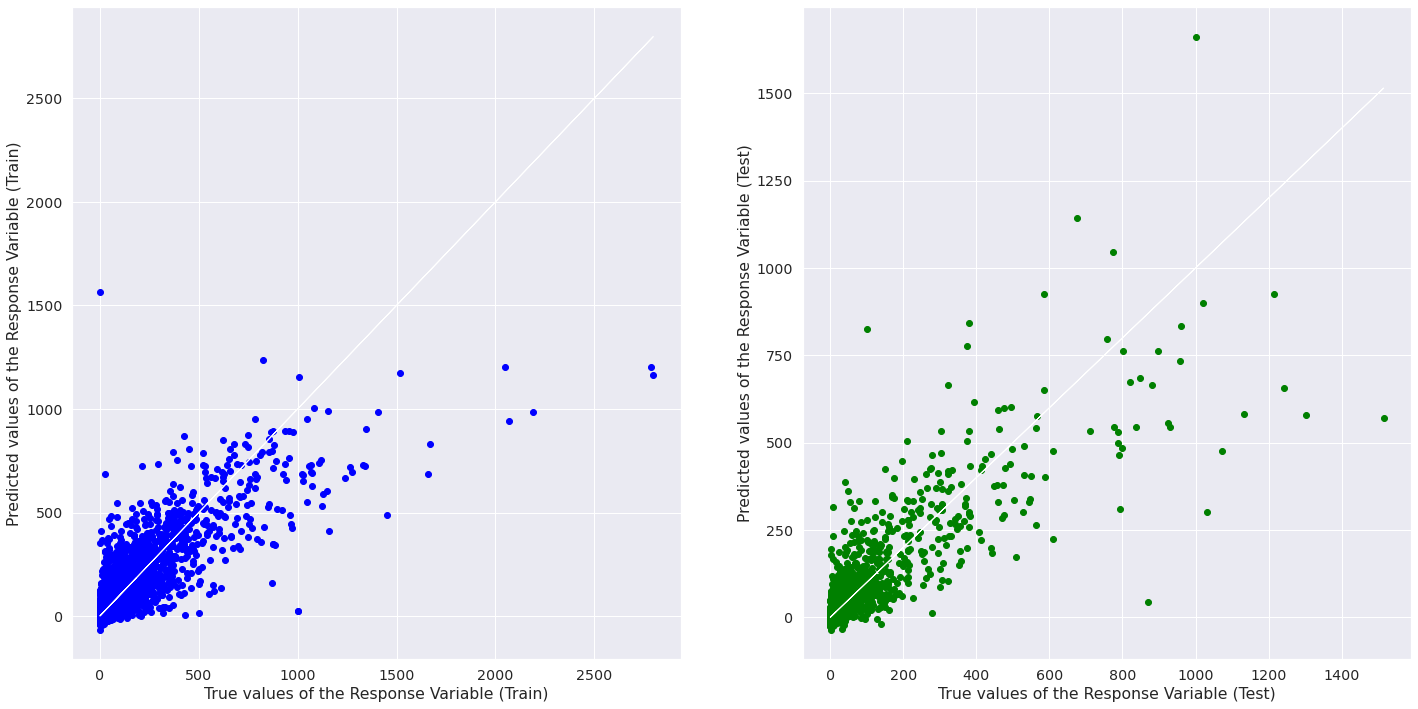

In [ ]:
# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

**Goodness of fit Model**

In [ ]:
# Check the Goodness of Fit (on Train Data)
print("Linear Regression \n")
print("Goodness of Fit of Model, \tTrain Dataset")
print("Explained Variance (R^2) \t:", lin_reg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print("Linear Regression (RMSE) \t:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", lin_reg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print("Linear Regression (RMSE) \t:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print()

Linear Regression 

Goodness of Fit of Model, 	Train Dataset
Explained Variance (R^2) 	: 0.6910089405516093
Mean Squared Error (MSE) 	: 8959.836482536246
Linear Regression (RMSE) 	: 94.65641279140175

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.6804795565264334
Mean Squared Error (MSE) 	: 8747.082688204158
Linear Regression (RMSE) 	: 93.52583968189839



#### DecisionTreeRegressor

RMSE of train: 1.66 * 10^-6

RMSE of test: 128.74

**Decison Tree overfits really badly on train set hence predictions on test set are not as good as Linear Regression**

In [ ]:
#Training 

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [ ]:
y_train_pred = tree_reg.predict(X_train)

In [ ]:
y_test_pred = tree_reg.predict(X_test)

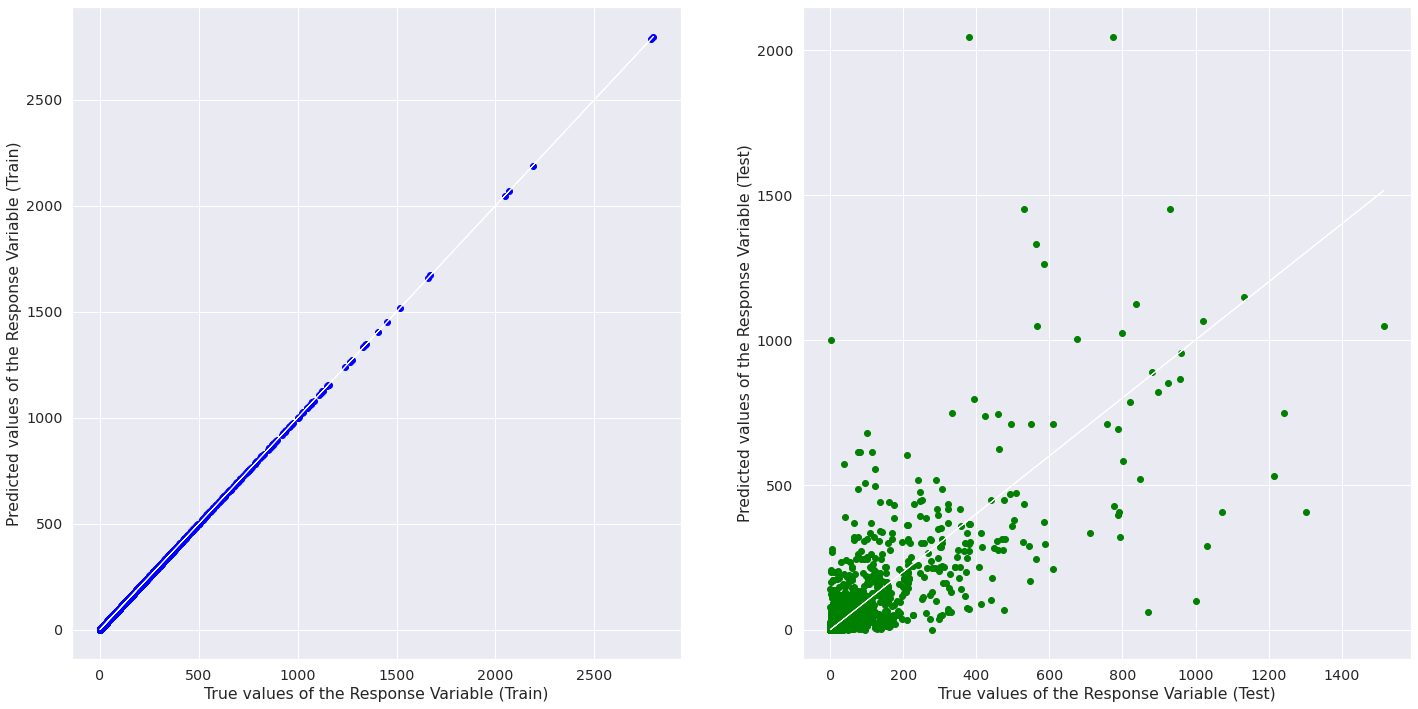

In [ ]:
# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

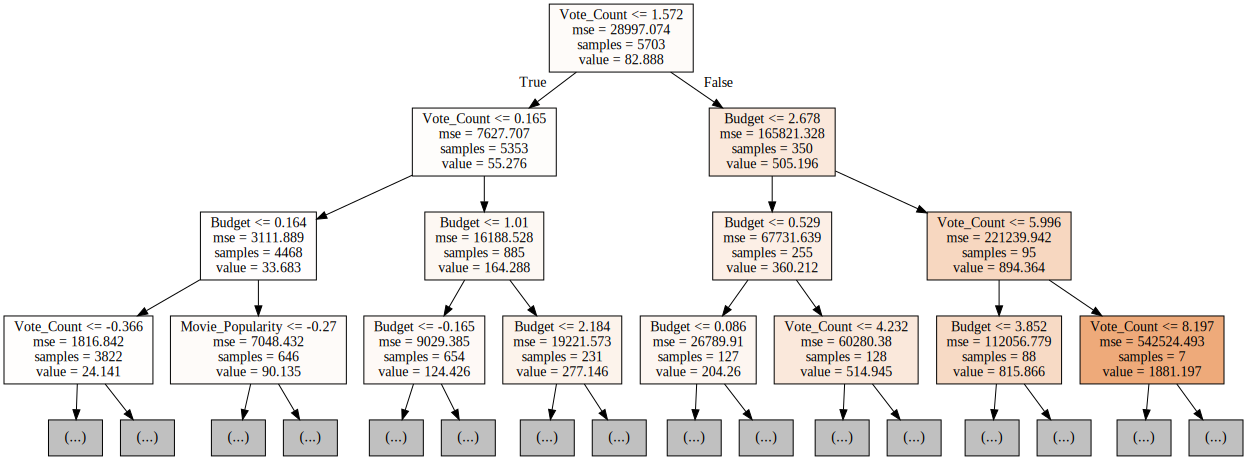

In [ ]:
labels = X_train.columns
graph = Source(tree.export_graphviz(tree_reg ,feature_names = labels, class_names = y_train.unique(), max_depth = 3, filled = True))
display(SVG(graph.pipe(format='svg')))

**Goodness of fit**

In [ ]:
# Check the Goodness of Fit (on Train Data)
print("Decision Tree \n")
print("Goodness of Fit of Model \tTrain Dataset")
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print("Decision Tree Regressor (RMSE) \t:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print("Decision Tree Regressor (RMSE) \t:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print()

Decision Tree 

Goodness of Fit of Model 	Train Dataset
Mean Squared Error (MSE) 	: 2.777836226714119e-12
Decision Tree Regressor (RMSE) 	: 1.6666842012553305e-06

Goodness of Fit of Model 	Test Dataset
Mean Squared Error (MSE) 	: 16574.63728033903
Decision Tree Regressor (RMSE) 	: 128.7425232016952



#### Ensemble Learning using Random Forest Regressor

RMSE of train: 32.29

RMSE of test: 84.95

**Best model**

In [ ]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
y_train_pred = forest_reg.predict(X_train)

In [ ]:
y_test_pred = forest_reg.predict(X_test)

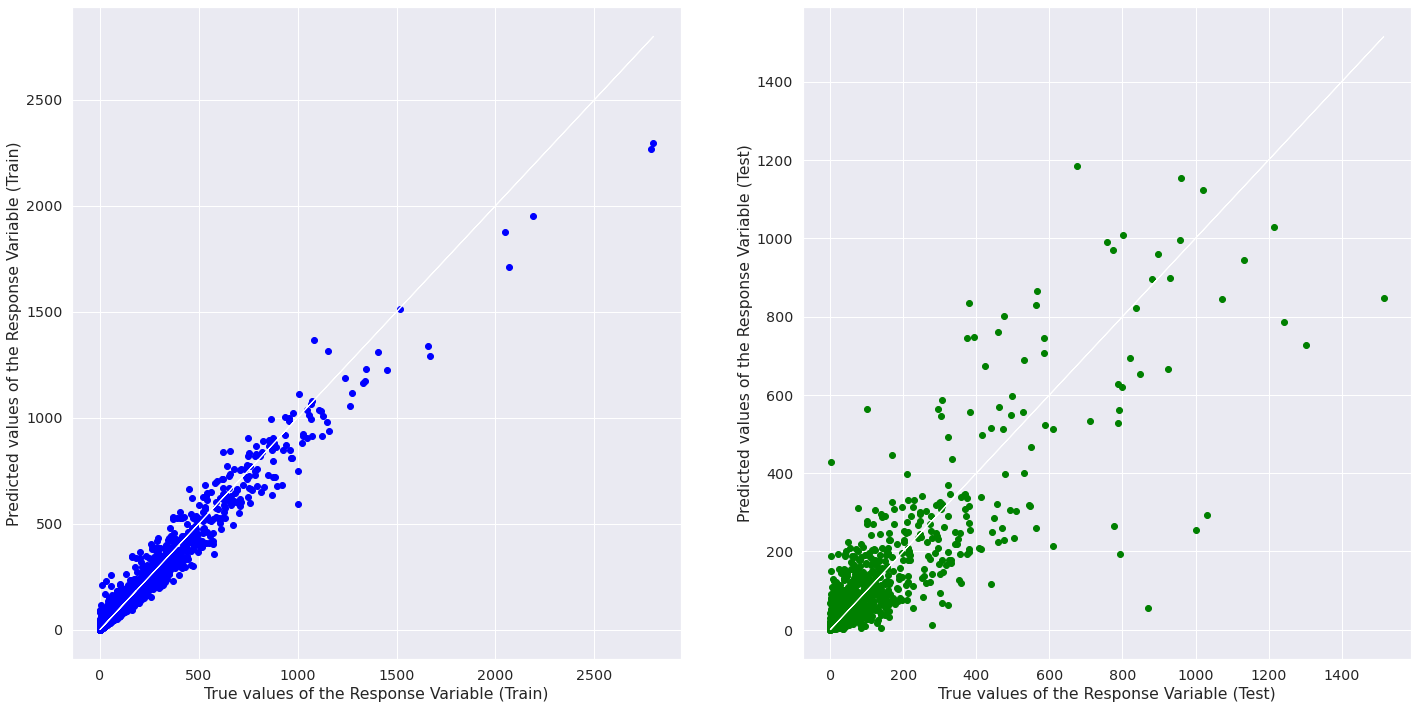

In [ ]:
# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

**Goodness of fit**

In [ ]:
# Check the Goodness of Fit (on Train Data)
print("Random Forest Regressor \n")
print("Goodness of Fit of Model \tTrain Dataset")
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print("Random Forest Regressor (RMSE) \t:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print("Random Forest Regressor (RMSE) \t:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print()

Random Forest Regressor 

Goodness of Fit of Model 	Train Dataset
Mean Squared Error (MSE) 	: 1043.0523185892123
Random Forest Regressor (RMSE) 	: 32.296320511618845

Goodness of Fit of Model 	Test Dataset
Mean Squared Error (MSE) 	: 7217.553982611808
Random Forest Regressor (RMSE) 	: 84.95618860690378



#### SVM Model

**Linear is the best**

RMSE of train: 100.16

RMSE of test: 95.76

In [ ]:
#Training
svm_reg = SVR(kernel="linear")
svm_reg.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
y_train_pred = svm_reg.predict(X_train)

In [ ]:
y_test_pred = svm_reg.predict(X_test)

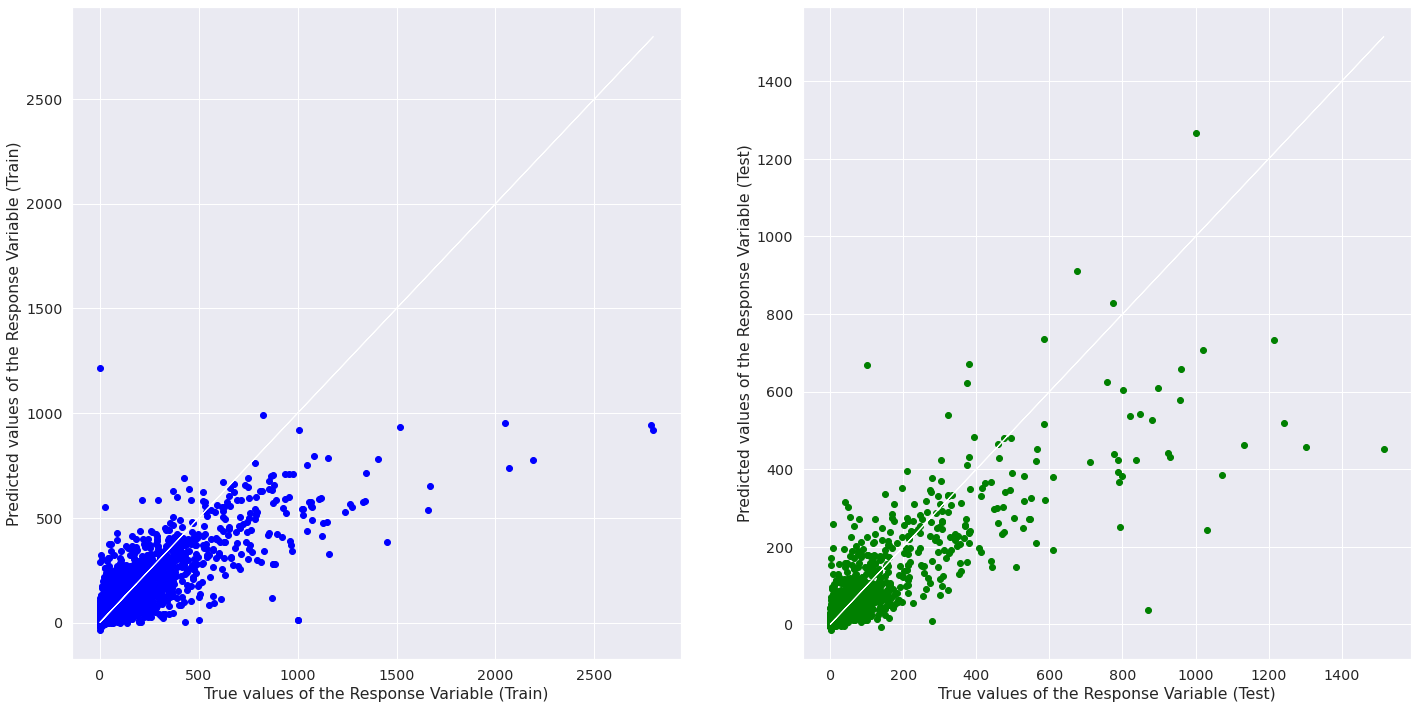

In [ ]:
# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

**Goodness of fit**

In [ ]:
# Check the Goodness of Fit (on Train Data)
print("SVM Linear Kernel \n")
print("Goodness of Fit of Model \tTrain Dataset")
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print("SVM (RMSE) \t:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print("SVM (RMSE) \t:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print()

SVM Linear Kernel 

Goodness of Fit of Model 	Train Dataset
Mean Squared Error (MSE) 	: 10032.919664087427
SVM (RMSE) 	: 100.16446307991386

Goodness of Fit of Model 	Test Dataset
Mean Squared Error (MSE) 	: 9171.447718875272
SVM (RMSE) 	: 95.76767575166096



**Trying a different kernel, polynomial kernel**

In [ ]:
#Training
svm_reg = SVR(kernel="poly")
svm_reg.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
y_train_pred = svm_reg.predict(X_train)

In [ ]:
y_test_pred = svm_reg.predict(X_test)

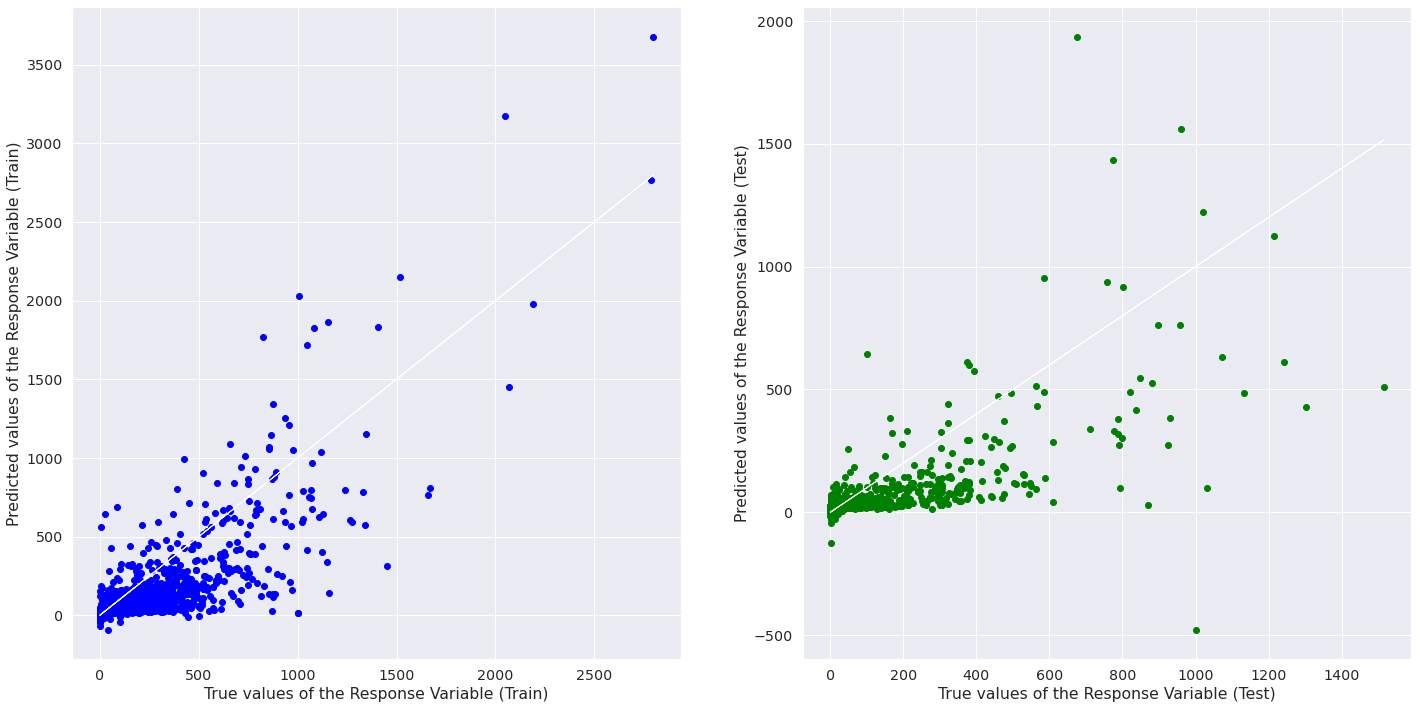

In [ ]:
# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

**Goodness of fit**

In [ ]:
# Check the Goodness of Fit (on Train Data)
print("SVM Polynomial Kernel \n")
print("Goodness of Fit of Model \tTrain Dataset")
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print("SVM (RMSE) \t:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print("SVM (RMSE) \t:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print()

SVM Polynomial Kernel 

Goodness of Fit of Model 	Train Dataset
Mean Squared Error (MSE) 	: 11876.506031831788
SVM (RMSE) 	: 108.97938351739649

Goodness of Fit of Model 	Test Dataset
Mean Squared Error (MSE) 	: 15752.601645177854
SVM (RMSE) 	: 125.50936875459877



**Trying rbf kernel**

In [ ]:
#Training
svm_reg = SVR(kernel="rbf")
svm_reg.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
y_train_pred = svm_reg.predict(X_train)

In [ ]:
y_test_pred = svm_reg.predict(X_test)

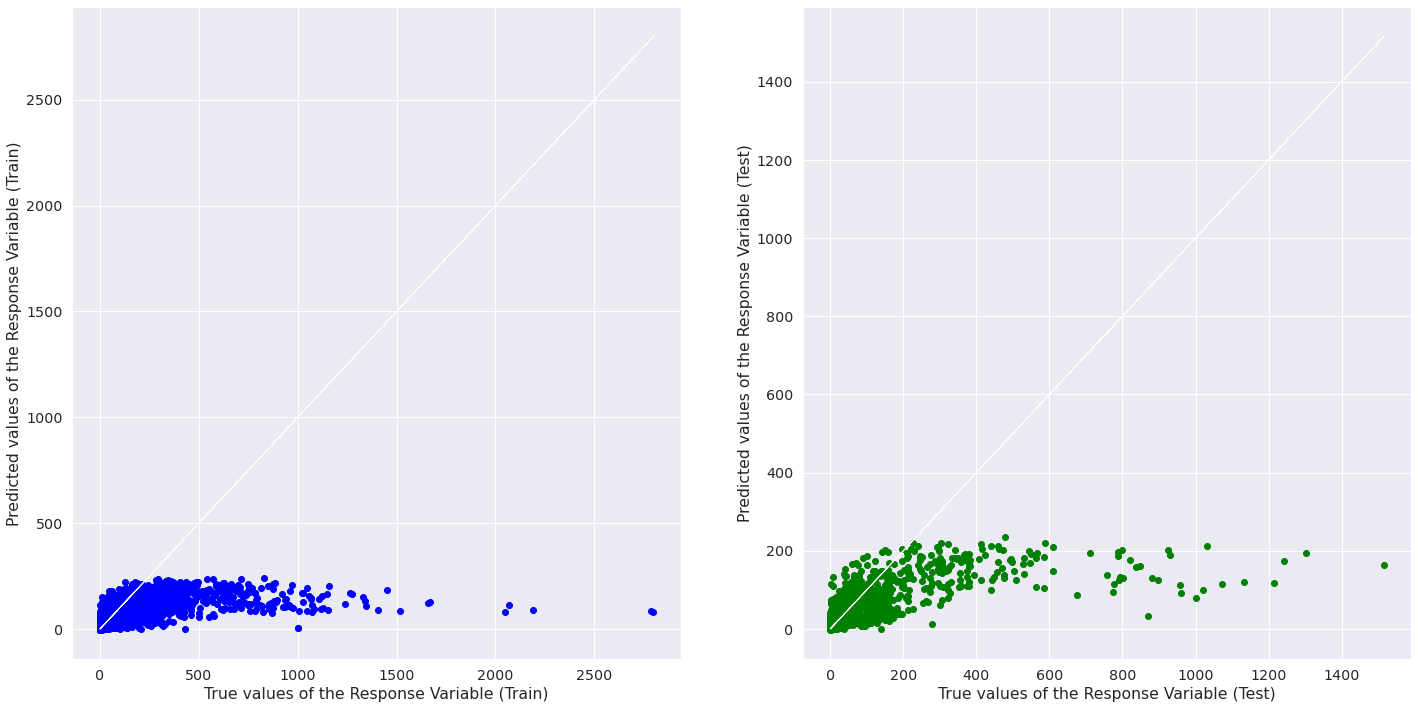

In [ ]:
# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

**Goodness of fit**

In [ ]:
# Check the Goodness of Fit (on Train Data)
print("SVM rbf kernel \n")
print("Goodness of Fit of Model \tTrain Dataset")
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print("SVM (RMSE) \t:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print("SVM (RMSE) \t:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print()

SVM rbf kernel 

Goodness of Fit of Model 	Train Dataset
Mean Squared Error (MSE) 	: 22210.82363961271
SVM (RMSE) 	: 149.03296158773975

Goodness of Fit of Model 	Test Dataset
Mean Squared Error (MSE) 	: 19653.988616304134
SVM (RMSE) 	: 140.19268389008084



## Section 5: Fine-tuning of Models and final model prediction
**(Better evaluation using cross-validation scores on test set)**

#### Comparison of Models (Testing out how CrossValidation works)

**Extra**

In [ ]:
#Imports
from sklearn.model_selection import cross_val_score

In [ ]:
def display_scores(scores):
    print("RMSE Scores: ", scores)
    print()
    print("Average RMSE: ", scores.mean())
    print()
    print("Standard deviation of RMSE: ", scores.std())

**Linear Regression Model Score**

In [ ]:
lin_reg_scores = cross_val_score(lin_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
lin_reg_rmse_scores = np.sqrt(-lin_reg_scores)

print("Linear Regression scores(Train) \n")
display_scores(lin_reg_rmse_scores)
print()
print(pd.Series(np.sqrt(-lin_reg_scores)).describe())

Linear Regression scores(Train) 

RMSE Scores:  [ 93.94096849  93.01642698  87.26279404  74.92904922 115.76613377
  64.8107175  107.74096285  92.605682   104.79668022 117.03777654]

Average RMSE:  95.19071916142421

Standard deviation of RMSE:  15.999150957689293

count     10.000000
mean      95.190719
std       16.864586
min       64.810718
25%       88.598516
50%       93.478698
75%      107.004892
max      117.037777
dtype: float64


In [ ]:
lin_reg_scores = cross_val_score(lin_reg, X_test, y_test, scoring="neg_mean_squared_error", cv=10)
lin_reg_rmse_scores = np.sqrt(-lin_reg_scores)

print("Linear Regression scores(Test) \n")
display_scores(lin_reg_rmse_scores)
print()
print(pd.Series(np.sqrt(-lin_reg_scores)).describe())

Linear Regression scores(Test) 

RMSE Scores:  [ 82.32552516 105.80284912  88.16389101  94.25219752  83.58866802
 119.36279944  67.61708883 113.9108022  109.18456492  86.31387311]

Average RMSE:  95.05222593300019

Standard deviation of RMSE:  15.596363745892967

count     10.000000
mean      95.052226
std       16.440011
min       67.617089
25%       84.269969
50%       91.208044
75%      108.339136
max      119.362799
dtype: float64


**Decision Tree Regressor Score**

In [ ]:
scores = cross_val_score(tree_reg, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
print("Decision Tree Score(Train) \n ")
display_scores(tree_rmse_scores)

Decision Tree Score(Train) 
 
RMSE Scores:  [127.01041256 107.58599299 115.4828797  107.06464261 122.74784916
  92.93220512 122.23998461 111.07618913 127.34998604 102.26309336]

Average RMSE:  113.57532352949875

Standard deviation of RMSE:  10.824531866707963


In [ ]:
scores = cross_val_score(tree_reg, X_test, y_test,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
print("Decision Tree Score(Test) \n ")
display_scores(tree_rmse_scores)

Decision Tree Score(Test) 
 
RMSE Scores:  [ 92.81344983 157.86492417 109.93574379 101.06379501 120.68953794
 112.97183254 102.33194939 123.67026308 137.99551985  95.38414591]

Average RMSE:  115.47211614899197

Standard deviation of RMSE:  19.320955552774134


**Observation**

**Linear Regression model** performs better than Decision Tree Regressor model with the test set

**Reason**: Decision Tree Regressor model is overfitting badly that it perofrms worse than the Linear Regression model(shown in cross validations)

**Random Forest Regressor scores**

**Still Best Model**

In [ ]:
forest_scores = cross_val_score(forest_reg, X_train, y_train,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

print("Random Forest Regressor score (Train) \n ")
display_scores(forest_rmse_scores)

Random Forest Regressor score (Train) 
 
RMSE Scores:  [ 94.25332055  80.09598808  85.43397782  72.32015869  96.00455343
  69.416474    93.95634337  77.88337259 100.49213199  76.17541507]

Average RMSE:  84.60317356032964

Standard deviation of RMSE:  10.400738810311768


In [ ]:
forest_scores = cross_val_score(forest_reg, X_test, y_test,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

print("Random Forest Regressor score (Test)\n ")
display_scores(forest_rmse_scores)

Random Forest Regressor score (Test)
 
RMSE Scores:  [ 68.22644838 102.71686807  87.20752647  68.38256969  75.99802907
  97.61359785  71.44211456  82.92681549 104.11053892  71.11560429]

Average RMSE:  82.97401127709047

Standard deviation of RMSE:  13.49609993165004


**Observation**

**Random Forest Regressor** is performing the best among all models for both test set

**SVM scores**

In [ ]:
svm_scores_rbf = cross_val_score(svm_reg, X_train, y_train,scoring="neg_mean_squared_error", cv=10)

svm_rbf_rmse_scores = np.sqrt(-svm_scores_rbf)
print("SVM scores (Train) \n")
display_scores(svm_rbf_rmse_scores)

SVM scores (Train) 

RMSE Scores:  [146.12215785 129.51778239 141.2580167  124.41990452 187.10912979
  97.98863746 194.41151777 165.88220424 151.89195486 141.53084312]

Average RMSE:  148.01321486930965

Standard deviation of RMSE:  27.40082495957666


In [ ]:
svm_scores_rbf = cross_val_score(svm_reg, X_test, y_test,scoring="neg_mean_squared_error", cv=10)

svm_rbf_rmse_scores = np.sqrt(-svm_scores_rbf)
print("SVM scores (Test) \n")
display_scores(svm_rbf_rmse_scores)

SVM scores (Test) 

RMSE Scores:  [132.38061151 197.17644529 171.64783613 149.80423877 151.84427177
 125.16995708 161.46561357 186.98250738 137.37457912 164.63970351]

Average RMSE:  157.84857641146843

Standard deviation of RMSE:  22.09422128762435


#### Gridsearch to tune and pick best model

Comparing RMSE of test sets of all tuned models and picking the best

In [ ]:
#Imports

from sklearn.model_selection import GridSearchCV

##### Linear Regression hyper paramater tuning and result

RMSE of test: 93.52

In [ ]:
%%time

param_grid = [
    #Try true,false
    {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True,False]},
  ]

lin_reg = LinearRegression()
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search_LinearReg = GridSearchCV(lin_reg, param_grid, cv=10, # 5
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search_LinearReg.fit(X_train, y_train)

CPU times: user 821 ms, sys: 1.03 s, total: 1.85 s
Wall time: 953 ms


In [ ]:
grid_search_LinearReg.best_params_

{'copy_X': True, 'fit_intercept': True, 'normalize': False}

In [ ]:
grid_search_LinearReg.best_estimator_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
cvres = grid_search_LinearReg.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

96.53600587754048 {'copy_X': True, 'fit_intercept': True, 'normalize': True}
96.5258817407853 {'copy_X': True, 'fit_intercept': True, 'normalize': False}
96.5258817407853 {'copy_X': True, 'fit_intercept': False, 'normalize': True}
96.5258817407853 {'copy_X': True, 'fit_intercept': False, 'normalize': False}
96.53600587754048 {'copy_X': False, 'fit_intercept': True, 'normalize': True}
96.5258817407853 {'copy_X': False, 'fit_intercept': True, 'normalize': False}
96.5258817407853 {'copy_X': False, 'fit_intercept': False, 'normalize': True}
96.5258817407853 {'copy_X': False, 'fit_intercept': False, 'normalize': False}


In [ ]:
pd.DataFrame(grid_search_LinearReg.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_copy_X,param_fit_intercept,param_normalize,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.013042,0.002015,0.002384,0.001730,True,True,True,"{'copy_X': True, 'fit_intercept': True, 'norma...",-8824.905562,-8673.252975,-7614.795224,-5614.362417,-13400.176500,-4200.398894,-11608.115077,-8575.812338,-10982.344185,-13697.841137,-9319.200431,2964.442442,7,-8977.666466,-9.006014e+03,-9144.652434,-9332.577955,-8.492486e+03,-9.489442e+03,-8683.329760,-9006.136691,-8741.429953,-8561.149137,-8.943488e+03,3.093577e+02
1,0.011213,0.001647,0.001844,0.000546,True,True,False,"{'copy_X': True, 'fit_intercept': True, 'norma...",-8824.905562,-8652.055688,-7614.795224,-5614.362417,-13401.797729,-4200.429103,-11608.115077,-8575.812338,-10982.344185,-13697.841137,-9317.245846,2965.129195,1,-8977.666466,-9.000727e+03,-9144.652434,-9332.577955,-8.491881e+03,-9.489436e+03,-8683.329760,-9006.136691,-8741.429953,-8561.149137,-8.942899e+03,3.093420e+02
2,0.004713,0.001635,0.001438,0.000160,True,False,True,"{'copy_X': True, 'fit_intercept': False, 'norm...",-8824.905562,-8652.055688,-7614.795224,-5614.362417,-13401.797729,-4200.429103,-11608.115077,-8575.812338,-10982.344185,-13697.841137,-9317.245846,2965.129195,1,-8977.666466,-9.000727e+03,-9144.652434,-9332.577955,-8.491881e+03,-9.489436e+03,-8683.329760,-9006.136691,-8741.429953,-8561.149137,-8.942899e+03,3.093420e+02
3,0.011111,0.004378,0.001507,0.000086,True,False,False,"{'copy_X': True, 'fit_intercept': False, 'norm...",-8824.905562,-8652.055688,-7614.795224,-5614.362417,-13401.797729,-4200.429103,-11608.115077,-8575.812338,-10982.344185,-13697.841137,-9317.245846,2965.129195,1,-8977.666466,-9.000727e+03,-9144.652434,-9332.577955,-8.491881e+03,-9.489436e+03,-8683.329760,-9006.136691,-8741.429953,-8561.149137,-8.942899e+03,3.093420e+02
4,0.006589,0.002958,0.001534,0.000223,False,True,True,"{'copy_X': False, 'fit_intercept': True, 'norm...",-8824.905562,-8673.252975,-7614.795224,-5614.362417,-13400.176500,-4200.398894,-11608.115077,-8575.812338,-10982.344185,-13697.841137,-9319.200431,2964.442442,7,-28520.632956,-1.814022e+31,-28713.295330,-29249.166884,-1.672020e+30,-9.489560e+27,-26764.253116,-27917.088349,-28366.964596,-28664.555220,-1.982173e+30,5.409005e+30
5,0.004668,0.000927,0.001749,0.000617,False,True,False,"{'copy_X': False, 'fit_intercept': True, 'norm...",-8824.905562,-8652.055688,-7614.795224,-5614.362417,-13401.797729,-4200.429103,-11608.115077,-8575.812338,-10982.344185,-13697.841137,-9317.245846,2965.129195,1,-8984.365428,-9.014809e+03,-9172.671361,-9341.950558,-8.503623e+03,-9.493890e+03,-8697.206564,-9024.760969,-8763.808506,-8585.759340,-8.958285e+03,3.065621e+02
6,0.004164,0.001187,0.001379,0.000091,False,False,True,"{'copy_X': False, 'fit_intercept': False, 'nor...",-8824.905562,-8652.055688,-7614.795224,-5614.362417,-13401.797729,-4200.429103,-11608.115077,-8575.812338,-10982.344185,-13697.841137,-9317.245846,2965.129195,1,-8977.666466,-9.000727e+03,-9144.652434,-9332.577955,-8.491881e+03,-9.489436e+03,-8683.329760,-9006.136691,-8741.429953,-8561.149137,-8.942899e+03,3.093420e+02
7,0.004205,0.001102,0.001418,0.000155,False,False,False,"{'copy_X': False, 'fit_intercept': False, 'nor...",-8824.905562,-8652.055688,-7614.795224,-5614.362417,-13401.797729,-4200.429103,-11608.115077,-8575.812338,-10982.344185,-13697.841137,-9317.245846,2965.129195,1,-8977.666466,-9.000727e+03,-9144.652434,-9332.577955,-8.491881e+03,-9.489436e+03,-8683.329760,-9006.136691,-8741.429953,-8561.149137,-8.942899e+03,3.093420e+02


In [ ]:
# Using tuned linear reg for predictions for new data
final_model_LinearReg = grid_search_LinearReg.best_estimator_


final_test_LinearReg_pred = final_model_LinearReg.predict(X_test) #(test set)

final_mse_LinearReg = mean_squared_error(y_test, final_test_LinearReg_pred) # y_test
final_rmse_LinearReg = np.sqrt(final_mse_LinearReg)

print("Linear Regression:\n")
print("root mean squared error of test is: ", final_rmse_LinearReg)

Linear Regression:

root mean squared error of test is:  93.52583968189839


##### Decision Tree hyperparameter

RMSE of test: 97.38

In [ ]:
%%time


param_grid = [
              { 'criterion': ['mse', 'friedman_mse', 'mae'],
                'splitter': ['best','random'],
                'max_depth': [2,4,6,8,10,12],
                'max_features': [2, 4, 6, 8, 10]
              }
  ]

tree_reg = DecisionTreeRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search_DecisionTree = GridSearchCV(tree_reg, param_grid, cv=10, # 5
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search_DecisionTree.fit(X_train, y_train)

CPU times: user 3min 58s, sys: 239 ms, total: 3min 59s
Wall time: 3min 58s


In [ ]:
grid_search_DecisionTree.best_params_

{'criterion': 'mse', 'max_depth': 4, 'max_features': 10, 'splitter': 'best'}

In [ ]:
grid_search_DecisionTree.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=4,
                      max_features=10, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [ ]:
cvres = grid_search_DecisionTree.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

149.73878965943936 {'criterion': 'mse', 'max_depth': 2, 'max_features': 2, 'splitter': 'best'}
166.7693064427604 {'criterion': 'mse', 'max_depth': 2, 'max_features': 2, 'splitter': 'random'}
146.03569334602568 {'criterion': 'mse', 'max_depth': 2, 'max_features': 4, 'splitter': 'best'}
164.6129641601876 {'criterion': 'mse', 'max_depth': 2, 'max_features': 4, 'splitter': 'random'}
133.69125133420815 {'criterion': 'mse', 'max_depth': 2, 'max_features': 6, 'splitter': 'best'}
126.66330072704233 {'criterion': 'mse', 'max_depth': 2, 'max_features': 6, 'splitter': 'random'}
131.35032319418346 {'criterion': 'mse', 'max_depth': 2, 'max_features': 8, 'splitter': 'best'}
123.51704254816255 {'criterion': 'mse', 'max_depth': 2, 'max_features': 8, 'splitter': 'random'}
114.65852900356636 {'criterion': 'mse', 'max_depth': 2, 'max_features': 10, 'splitter': 'best'}
115.7380420919787 {'criterion': 'mse', 'max_depth': 2, 'max_features': 10, 'splitter': 'random'}
130.45189428501493 {'criterion': 'mse', '

In [ ]:
pd.DataFrame(grid_search_DecisionTree.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.003345,0.000479,0.001149,0.000303,mse,2,2,best,"{'criterion': 'mse', 'max_depth': 2, 'max_feat...",-20959.289768,-16528.309969,-18951.637431,-14510.223006,-32034.502460,-12389.084869,-28272.913860,-31860.585115,-28361.975820,-20348.528989,-22421.705129,6837.228974,163,-22586.251323,-23087.386046,-22811.046867,-23303.263884,-20748.423550,-23539.828565,-18498.537309,-26489.578344,-26877.852635,-22652.892251,-23059.506077,2307.176769
1,0.002272,0.000083,0.000929,0.000028,mse,2,2,random,"{'criterion': 'mse', 'max_depth': 2, 'max_feat...",-28150.914060,-22685.053622,-27950.889036,-21646.610360,-37145.501579,-15665.367990,-34874.480079,-33856.622608,-29647.939734,-26496.636645,-27812.001571,6249.828999,176,-27253.440120,-27860.592230,-27239.048744,-27975.559655,-26258.780943,-28640.234941,-26683.838254,-26619.006826,-27086.221870,-28940.509058,-27455.723264,836.347709
2,0.003714,0.000130,0.001007,0.000038,mse,2,4,best,"{'criterion': 'mse', 'max_depth': 2, 'max_feat...",-24141.743804,-19357.708348,-22342.594942,-15329.530386,-32121.543381,-12965.127766,-25274.271332,-20305.198351,-21940.522346,-19485.996655,-21326.423731,5056.043616,159,-19957.359368,-20310.109062,-19565.744869,-20757.281069,-19538.420791,-21168.145250,-19392.485842,-19751.959490,-19568.635056,-19861.954310,-19987.209511,554.233758
3,0.002403,0.000196,0.000926,0.000051,mse,2,4,random,"{'criterion': 'mse', 'max_depth': 2, 'max_feat...",-27512.234391,-22758.763923,-25007.719977,-19322.885288,-36700.960971,-14676.889025,-41969.158029,-30855.892458,-28232.095652,-23937.679983,-27097.427970,7595.195755,174,-26843.712336,-26016.113059,-27118.435515,-27741.895259,-25871.292022,-28259.981389,-25229.036305,-26464.900819,-26752.709805,-27229.852912,-26752.792942,856.968188
4,0.005162,0.000027,0.001060,0.000030,mse,2,6,best,"{'criterion': 'mse', 'max_depth': 2, 'max_feat...",-19717.927355,-15587.285640,-15892.167575,-11179.050177,-26648.376991,-11344.355031,-22940.211806,-17327.021748,-20019.710885,-18077.399625,-17873.350683,4556.492381,147,-16853.350683,-17185.416652,-17135.827985,-17665.861203,-16345.622449,-18100.151122,-16363.404358,-16975.406080,-16745.851769,-16901.712632,-17027.260493,512.730677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.357871,0.020594,0.001442,0.000132,mae,12,6,random,"{'criterion': 'mae', 'max_depth': 12, 'max_fea...",-14312.540994,-10951.024404,-12267.579464,-10756.550403,-14708.833018,-6901.778630,-11171.766532,-16877.301320,-14751.472124,-9948.179660,-12264.702655,2773.977798,67,-4292.570414,-3203.831897,-3295.095775,-3045.542141,-3235.434626,-3887.897394,-2708.797160,-3777.415140,-3498.572059,-3525.502161,-3447.065877,431.329758
176,0.595102,0.018151,0.001471,0.000168,mae,12,8,best,"{'criterion': 'mae', 'max_depth': 12, 'max_fea...",-14917.252898,-9226.325622,-13240.040399,-8724.471811,-16347.178107,-6738.796239,-16765.433445,-10549.741299,-13952.139739,-8969.855162,-11943.123472,3358.891570,57,-1401.259621,-1393.135362,-1596.178468,-1612.974434,-1111.098507,-1715.558318,-1734.627127,-2011.458680,-1690.943791,-1602.234361,-1586.946867,229.966668
177,0.430508,0.028481,0.001417,0.000110,mae,12,8,random,"{'criterion': 'mae', 'max_depth': 12, 'max_fea...",-14918.561515,-11222.008508,-31104.625388,-6881.205342,-16654.396663,-8606.093876,-15243.656431,-7506.383958,-13909.95795

In [ ]:
# Using tuned Decision Tree for predictions for new data
final_model_DecisionTree = grid_search_DecisionTree.best_estimator_


final_test_DecisionTree_pred = final_model_DecisionTree.predict(X_test) #(test set)

final_mse_DecisionTree = mean_squared_error(y_test, final_test_DecisionTree_pred) # y_test
final_rmse_DecisionTree = np.sqrt(final_mse_DecisionTree)

print("Decision Tree: \n")
print("root mean squared error of test is: ", final_rmse_DecisionTree)

Decision Tree: 

root mean squared error of test is:  97.3832955936556


##### Random Forest hyperparameter
**Best**

RMSE of test: 82.32

In [ ]:
%%time

param_grid = [
    # combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 
     'max_features': [2, 4, 6, 8, 10], 
     'bootstrap': [True,False]
     }, 
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search_RandomForest = GridSearchCV(forest_reg, param_grid, cv=10, # 5
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search_RandomForest.fit(X_train, y_train)

CPU times: user 1min 49s, sys: 204 ms, total: 1min 49s
Wall time: 1min 49s


In [ ]:
grid_search_RandomForest.best_params_

{'bootstrap': True, 'max_features': 2, 'n_estimators': 30}

In [ ]:
grid_search_RandomForest.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=2, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
cvres = grid_search_RandomForest.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

102.22345433408614 {'bootstrap': True, 'max_features': 2, 'n_estimators': 3}
88.5761022197299 {'bootstrap': True, 'max_features': 2, 'n_estimators': 10}
85.40764010612777 {'bootstrap': True, 'max_features': 2, 'n_estimators': 30}
99.58400508364616 {'bootstrap': True, 'max_features': 4, 'n_estimators': 3}
91.09315147551526 {'bootstrap': True, 'max_features': 4, 'n_estimators': 10}
86.36610067932921 {'bootstrap': True, 'max_features': 4, 'n_estimators': 30}
102.39645522667614 {'bootstrap': True, 'max_features': 6, 'n_estimators': 3}
89.89797989294128 {'bootstrap': True, 'max_features': 6, 'n_estimators': 10}
86.04943767083157 {'bootstrap': True, 'max_features': 6, 'n_estimators': 30}
97.67586366683423 {'bootstrap': True, 'max_features': 8, 'n_estimators': 3}
89.63558772928184 {'bootstrap': True, 'max_features': 8, 'n_estimators': 10}
86.36825145932518 {'bootstrap': True, 'max_features': 8, 'n_estimators': 30}
99.71434461571721 {'bootstrap': True, 'max_features': 10, 'n_estimators': 3}
88

In [ ]:
pd.DataFrame(grid_search_RandomForest.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.027670,0.001640,0.002704,0.000375,True,2,3,"{'bootstrap': True, 'max_features': 2, 'n_esti...",-10504.456536,-10196.262337,-11148.962191,-6728.776068,-13287.980188,-7189.279999,-16342.421231,-9144.942902,-12050.299077,-7902.965630,-10449.634616,2802.890871,27,-2.562350e+03,-3.194214e+03,-2.678338e+03,-3.139300e+03,-3.103916e+03,-2.941077e+03,-2.789539e+03,-2.683067e+03,-2.268649e+03,-2.696136e+03,-2.805659e+03,2.758007e+02
1,0.088893,0.003313,0.004480,0.000399,True,2,10,"{'bootstrap': True, 'max_features': 2, 'n_esti...",-8942.581457,-7516.875908,-7358.792798,-5595.193589,-9440.185354,-4918.869683,-11110.736204,-7434.815699,-10233.057898,-5906.150254,-7845.725884,1949.678678,9,-1.508359e+03,-1.553449e+03,-1.417717e+03,-1.701640e+03,-1.537893e+03,-1.792866e+03,-1.592554e+03,-1.521299e+03,-1.324690e+03,-1.502583e+03,-1.545305e+03,1.252186e+02
2,0.261284,0.004358,0.009096,0.000158,True,2,30,"{'bootstrap': True, 'max_features': 2, 'n_esti...",-8301.231661,-7340.481127,-6576.118886,-4633.197437,-9564.751648,-3974.142331,-10170.609470,-7034.720851,-9784.964734,-5564.431739,-7294.464988,2057.379034,1,-1.238291e+03,-1.281663e+03,-1.198672e+03,-1.187300e+03,-1.110210e+03,-1.306652e+03,-1.198038e+03,-1.178481e+03,-1.064441e+03,-1.288066e+03,-1.205181e+03,7.352921e+01
3,0.040831,0.001676,0.002662,0.000440,True,4,3,"{'bootstrap': True, 'max_features': 4, 'n_esti...",-10973.904605,-9670.860193,-10458.990420,-6770.875331,-13096.255752,-6182.284179,-13096.133702,-10844.683278,-12533.110799,-5542.642426,-9916.974068,2690.200417,25,-2.409346e+03,-2.622480e+03,-2.516818e+03,-2.799047e+03,-2.649970e+03,-2.764790e+03,-2.590440e+03,-2.318247e+03,-2.472412e+03,-2.603952e+03,-2.574750e+03,1.422817e+02
4,0.134789,0.004434,0.004542,0.000510,True,4,10,"{'bootstrap': True, 'max_features': 4, 'n_esti...",-9284.280372,-7445.483008,-7335.996672,-5355.359272,-11298.511300,-4861.979599,-11599.391214,-9728.334011,-10695.290256,-5374.996754,-8297.962246,2435.762944,15,-1.373668e+03,-1.337765e+03,-1.373532e+03,-1.559408e+03,-1.511286e+03,-1.698282e+03,-1.443412e+03,-1.432814e+03,-1.306376e+03,-1.378541e+03,-1.441508e+03,1.126908e+02
5,0.398141,0.005800,0.009712,0.001249,True,4,30,"{'bootstrap': True, 'max_features': 4, 'n_esti...",-8180.605043,-7014.498174,-6670.648966,-4607.020248,-9480.920603,-4630.865780,-11118.880178,-7281.694133,-10033.291700,-5572.608641,-7459.103347,2125.363450,3,-1.086771e+03,-1.124966e+03,-1.111439e+03,-1.116799e+03,-1.103445e+03,-1.215195e+03,-1.156116e+03,-1.107158e+03,-1.089190e+03,-1.163753e+03,-1.127483e+03,3.784352e+01
6,0.054456,0.001406,0.002634,0.000280,True,6,3,"{'bootstrap': True, 'max_features': 6, 'n_esti...",-9842.448539,-8715.213162,-9481.818781,-7566.257277,-16688.789187,-6746.100578,-18368.267809,-8026.601686,-12124.476681,-7290.366730,-10485.034043,3829.099343,28,-2.547402e+03,-2.574569e+03,-2.775655e+03,-3.116718e+03,-2.556173e+03,-3.064502e+03,-2.591407e+03,-2.545437e+03,-2.048572e+03,-2.516507e+03,-2.633694e+03,2.866515e+02
7,0.182943,0.003064,0.004273,0.000127,True,6,10,"{'bootstrap': True, 'max_features': 6, 'n_esti...",-8905.976300,-6618.116965,-8091.550111,-5532.020856,-12610.697043,-4685.217298,-10330.445750,-6765.244566,-11053.421511,-6223.777489,-8081.646789,2458.521783,13,-1.362104e+03,-1.392469e+03,-1.516392e+03,-1.545422e+03,-1.399883e+03,-1.556290e+03,-1.447594e+03,-1.499077e+03,-1.356945e+03,-1.369013e+03,-1.444519e+03,7.462599e+01
8,0.5465

In [ ]:
# Using tuned Random Forest model for predictions for new data
final_model_RandomForest = grid_search_RandomForest.best_estimator_


final_test_RandomForest_pred = final_model_RandomForest.predict(X_test) #(test set)

final_mse_RandomForest = mean_squared_error(y_test, final_test_RandomForest_pred) # y_test
final_rmse_RandomForest = np.sqrt(final_mse_RandomForest)

print("Random Forest: \n")
print("root mean squared error is: ", final_rmse_RandomForest)

Random Forest: 

root mean squared error is:  82.3248029282692


**Hence we can tell that the most important feature is Vote_Count**, which also has the highest correlation with Revenue

##### SVM hyper parameter tuning

RMSE of test: 95.76

In [ ]:
%%time

param_grid = [
    {
        'shrinking': [True,False],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [2,4,6]
    }
  ]

svm_reg = SVR()
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search_SVM = GridSearchCV(svm_reg, param_grid, cv=10, # 5
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search_SVM.fit(X_train, y_train)

CPU times: user 21min 24s, sys: 3.81 s, total: 21min 27s
Wall time: 21min 25s


In [ ]:
grid_search_SVM.best_params_

{'degree': 2, 'kernel': 'linear', 'shrinking': True}

In [ ]:
grid_search_SVM.best_estimator_

SVR(C=1.0, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
cvres = grid_search_SVM.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

100.48059825806506 {'degree': 2, 'kernel': 'linear', 'shrinking': True}
100.48060389900127 {'degree': 2, 'kernel': 'linear', 'shrinking': False}
125.73890658020133 {'degree': 2, 'kernel': 'poly', 'shrinking': True}
125.73891912104182 {'degree': 2, 'kernel': 'poly', 'shrinking': False}
150.52812688801313 {'degree': 2, 'kernel': 'rbf', 'shrinking': True}
150.5281320552729 {'degree': 2, 'kernel': 'rbf', 'shrinking': False}
157.06745124006807 {'degree': 2, 'kernel': 'sigmoid', 'shrinking': True}
157.06326089062938 {'degree': 2, 'kernel': 'sigmoid', 'shrinking': False}
100.48059825806506 {'degree': 4, 'kernel': 'linear', 'shrinking': True}
100.48060389900127 {'degree': 4, 'kernel': 'linear', 'shrinking': False}
4269.284526485352 {'degree': 4, 'kernel': 'poly', 'shrinking': True}
4269.284526373634 {'degree': 4, 'kernel': 'poly', 'shrinking': False}
150.52812688801313 {'degree': 4, 'kernel': 'rbf', 'shrinking': True}
150.5281320552729 {'degree': 4, 'kernel': 'rbf', 'shrinking': False}
157.067

In [ ]:
pd.DataFrame(grid_search_SVM.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_degree,param_kernel,param_shrinking,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,1.400414,0.041741,0.037934,0.000865,2,linear,True,"{'degree': 2, 'kernel': 'linear', 'shrinking':...",-9.917694e+03,-9033.303816,-7.178566e+03,-6.086260e+03,-15899.593338,-4528.156664,-15102.681082,-10639.199559,-11787.372864,-1.079068e+04,-1.009635e+04,3.451643e+03,1,-10130.640673,-10053.811086,-10299.253741,-10507.772386,-9422.223095,-10663.555164,-9642.369613,-10070.692651,-9663.798638,-9887.807471,-10034.192452,372.599524
1,2.880366,0.772387,0.038398,0.001472,2,linear,False,"{'degree': 2, 'kernel': 'linear', 'shrinking':...",-9.917686e+03,-9033.332878,-7.178590e+03,-6.086260e+03,-15899.611938,-4528.143917,-15102.624796,-10639.209786,-11787.370580,-1.079069e+04,-1.009635e+04,3.451637e+03,4,-10130.634584,-10053.849175,-10299.282637,-10507.773840,-9422.234658,-10663.509131,-9642.348917,-10070.698009,-9663.799263,-9887.809423,-10034.193964,372.594223
2,1.507363,0.046199,0.050446,0.001791,2,poly,True,"{'degree': 2, 'kernel': 'poly', 'shrinking': T...",-1.196138e+04,-10678.976384,-1.187871e+04,-7.123626e+03,-11384.570408,-6771.695894,-12971.260365,-9990.451612,-11754.823355,-6.358723e+04,-1.581027e+04,1.604480e+04,7,-13058.166312,-12824.223681,-11769.786804,-13056.770055,-12821.318751,-13516.584121,-13044.135939,-13493.434631,-12862.184223,-10127.808516,-12657.441303,958.652822
3,1.832141,0.121212,0.049716,0.000384,2,poly,False,"{'degree': 2, 'kernel': 'poly', 'shrinking': F...",-1.196138e+04,-10678.975672,-1.187873e+04,-7.123628e+03,-11384.566238,-6771.707640,-12971.266231,-9990.452653,-11754.825486,-6.358723e+04,-1.581028e+04,1.604480e+04,8,-13058.141171,-12824.222411,-11769.787105,-13056.774717,-12821.332710,-13516.757891,-13044.167558,-13493.434656,-12862.148582,-10127.808516,-12657.457532,958.668246
4,1.984454,0.009391,0.106206,0.001306,2,rbf,True,"{'degree': 2, 'kernel': 'rbf', 'shrinking': True}",-2.135169e+04,-16774.855956,-1.995383e+04,-1.548031e+04,-35009.826452,-9601.773070,-37795.838240,-27516.905685,-23071.165951,-2.003098e+04,-2.265872e+04,8.234181e+03,9,-22671.069385,-23078.899359,-23654.119075,-23149.959013,-21050.373267,-23781.555696,-21083.493688,-21968.258452,-22367.919935,-22825.992893,-22563.164076,907.506922
5,2.139411,0.011305,0.105815,0.001222,2,rbf,False,"{'degree': 2, 'kernel': 'rbf', 'shrinking': Fa...",-2.135170e+04,-16774.847815,-1.995383e+04,-1.548032e+04,-35009.826452,-9601.773070,-37795.838240,-27516.905685,-23071.165951,-2.003098e+04,-2.265872e+04,8.234180e+03,12,-22671.085980,-23078.888003,-23654.119075,-23149.968024,-21050.373267,-23781.555696,-21083.493688,-21968.258452,-22367.919935,-22825.992893,-22563.165501,907.507057
6,2.300650,0.047999,0.142334,0.002907,2,sigmoid,True,"{'degree': 2, 'kernel': 'sigmoid', 'shrinking'...",-2.259518e+04,-17163.238828,-2.271958e+04,-1.769987e+04,-38885.428399,-10698.021150,-40812.745787,-30303.215058,-23594.717298,-2.222984e+04,-2.467018e+04,8.998720e+03,18,-25027.078630,-25244.226987,-28010.693004,-25101.254972,-22855.883106,-26182.568705,-22524.728436,-23691.774342,-24464.099986,-24671.801997,-24777.411016,1512.232750
7,2.510043,0.053192,0.142810,0.003117,2,sigmoid,False,"{'degree': 2, 'kernel': 'sigmoid', 'shrinking'...",-2.269008e+04,-17163.238848,-2.271976e+04,-1.769994e+04,-38885.396375,-10698.002053,-40809.351849,-30294.928596,-23498.136919,-2.222985e+04,-2.466887e+04,8.996650e+03,15,-25088.029049,-25244.229567,-28010.817303,-25101.340098,-22855.860759,-26182.531611,-22523.283815,-23686.154517,-24360.60

In [ ]:
# Using tuned linear reg for predictions for new data
final_model_SVM = grid_search_SVM.best_estimator_


final_test_SVM_pred = final_model_SVM.predict(X_test) #(test set)

final_mse_SVM = mean_squared_error(y_test, final_test_SVM_pred) # y_test
final_rmse_SVM = np.sqrt(final_mse_SVM)

print("root mean squared error of test is: ", final_rmse_SVM)

root mean squared error of test is:  95.76767575166096


### Final testing using the best model from Grid Search

Use of grid search best model to predict

**RMSE of test: 82.32**

In [ ]:
# Using tuned model for predictions for new data
final_model_RandomForest = grid_search_RandomForest.best_estimator_

final_test_RandomForest_pred = final_model_RandomForest.predict(X_test) #(test set)

final_mse_RandomForest = mean_squared_error(y_test, final_test_RandomForest_pred) # y_test
final_rmse_RandomForest = np.sqrt(final_mse_RandomForest)

print("root mean squared error of test is: ", final_rmse_RandomForest)


root mean squared error of test is:  82.3248029282692


In [ ]:
# let's try the full preprocessing pipeline on a few training instances
some_data = X_test.iloc[:10] # train_set
some_labels = y_test.iloc[:10] # train_set

# If prediction for some data, need to first transform with full ML pipeline
#some_data_prepared = full_pipeline.transform(some_data)

print("Using best model from GridSearch to predict Revenue in millions \n")
print("Predictions :\n", final_model_RandomForest.predict(some_data))
print()
print("Labels :\n", list(some_labels))

Using best model from GridSearch to predict Revenue in millions 

Predictions :
 [  2.81539263 121.10126723  63.1253093   40.87154123  94.91615113
  42.72271023  20.80344693   4.4915113    3.69688853  38.44255903]

Labels :
 [0.362222, 63.408614, 173.95943799999998, 13.323144000000001, 5.774854, 3.719383, 17.6, 5.52, 4.5, 43.967255]


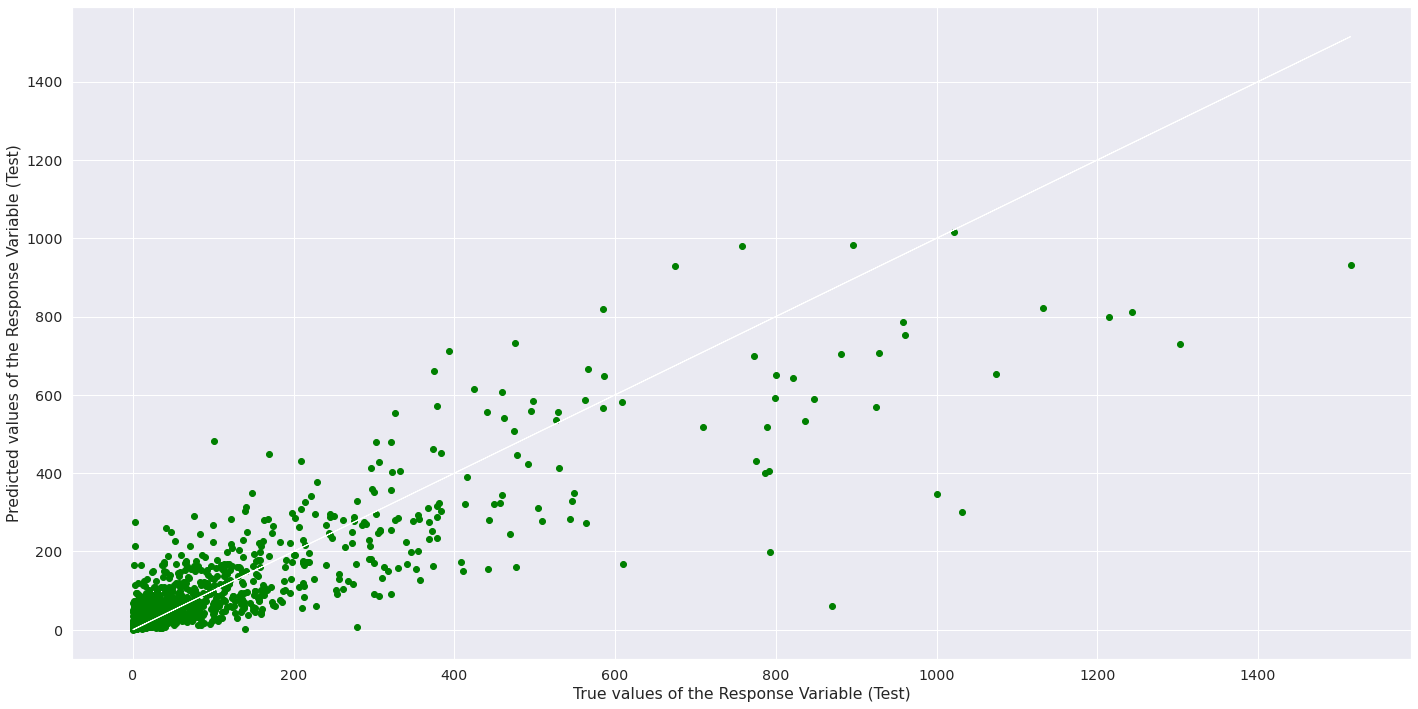

In [ ]:
# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 1, figsize=(24, 12))
axes.scatter(y_test, final_test_RandomForest_pred, color = "green")
axes.plot(y_test, y_test, 'w-', linewidth = 1)
axes.set_xlabel("True values of the Response Variable (Test)")
axes.set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

In [ ]:
# Feature importance
feature_importances = grid_search_RandomForest.best_estimator_.feature_importances_
feature_importances

array([0.19162547, 0.07466355, 0.27991191, 0.05688481, 0.28243254,
       0.09737154, 0.00699095, 0.00225579, 0.00346972, 0.00266604,
       0.00172768])

In [ ]:
X_train.head()

,Movie_Popularity,Duration,Budget,Vote_Average,Vote_Count,Actor_Popularity,PCC_OHE_1,PCC_OHE_2,PCC_OHE_3,PCC_OHE_4,PCC_OHE_5
6078,0.194778,1.119855,-0.223611,1.475483,1.184723,4.836048,0.0,0.0,1.0,0.0,0.0
420,0.066141,0.291841,-0.012173,0.938666,1.855976,0.290254,1.0,0.0,0.0,0.0,0.0
6245,-0.232769,-1.364186,-0.664106,1.475483,-0.563622,-0.424433,0.0,1.0,0.0,0.0,0.0
553,0.021488,-0.623332,-0.247104,-0.242332,1.514100,0.107685,1.0,0.0,0.0,0.0,0.0
1397,-0.118735,-0.274694,0.040686,0.079758,-0.318794,-0.119404,1.0,0.0,0.0,0.0,0.0


**Hence we can tell that the most important feature is Vote_Count, which also has the highest correlation with Revenue**

### Randomized search to improve best model

Does it faster than gridsearch for large dataset but not always better than gridsearch. Randomised

In [ ]:
#Imports

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [ ]:
%%time

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

CPU times: user 58.6 s, sys: 158 ms, total: 58.8 s
Wall time: 58.9 s


In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

85.32910759644895 {'max_features': 7, 'n_estimators': 180}
87.7629056683148 {'max_features': 5, 'n_estimators': 15}
85.19306169402651 {'max_features': 3, 'n_estimators': 72}
86.67488036470888 {'max_features': 5, 'n_estimators': 21}
85.34443118452064 {'max_features': 7, 'n_estimators': 122}
85.22684759507446 {'max_features': 3, 'n_estimators': 75}
85.10602255687863 {'max_features': 3, 'n_estimators': 88}
85.34643148871537 {'max_features': 5, 'n_estimators': 100}
85.48552400565092 {'max_features': 3, 'n_estimators': 150}
109.66300605574745 {'max_features': 5, 'n_estimators': 2}


In [ ]:
rnd_search.best_params_

{'max_features': 3, 'n_estimators': 88}

In [ ]:
# Feature importance
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([0.14872297, 0.06808138, 0.30550385, 0.04790648, 0.34819645,
       0.06622592, 0.00630122, 0.00255878, 0.00365735, 0.00185866,
       0.00098693])

In [ ]:
X_train.head()

,Movie_Popularity,Duration,Budget,Vote_Average,Vote_Count,Actor_Popularity,PCC_OHE_1,PCC_OHE_2,PCC_OHE_3,PCC_OHE_4,PCC_OHE_5
6078,0.194778,1.119855,-0.223611,1.475483,1.184723,4.836048,0.0,0.0,1.0,0.0,0.0
420,0.066141,0.291841,-0.012173,0.938666,1.855976,0.290254,1.0,0.0,0.0,0.0,0.0
6245,-0.232769,-1.364186,-0.664106,1.475483,-0.563622,-0.424433,0.0,1.0,0.0,0.0,0.0
553,0.021488,-0.623332,-0.247104,-0.242332,1.514100,0.107685,1.0,0.0,0.0,0.0,0.0
1397,-0.118735,-0.274694,0.040686,0.079758,-0.318794,-0.119404,1.0,0.0,0.0,0.0,0.0


### Final Testing using best model after random search

**RMSE of test: 83.81**

In [ ]:
# Using best model for predictions for new data
final_model = rnd_search.best_estimator_


final_test_pred = final_model.predict(X_test) #(test set)

final_mse = mean_squared_error(y_test, final_test_pred) # y_test
final_rmse = np.sqrt(final_mse)

print("root mean squared error is: ", final_rmse)

root mean squared error is:  83.81685690758783


### Thoughts about areas of improvement

1. One of the limits would be data collection. A good dataset would be about 100,000 data. Due to the lack of data from the website and ability to extract huge amounts of data, the train sets are often very overfitted. With better amount of data, the mean squared error will be further reduced
2. Since there are many outliers in the data, it could be further improved with better techniques that could remove outliers to median or average for better estimates.

In [ ]:
# let's try the full preprocessing pipeline on a few training instances
some_data = X_test.iloc[:10] # train_set
some_labels = y_test.iloc[:10] # train_set

# If prediction for some data, need to first transform with full ML pipeline
#some_data_prepared = full_pipeline.transform(some_data)

print("Predictions :\n", final_model_RandomForest.predict(some_data))
print()
print("Labels :\n", list(some_labels))

Predictions :
 [  4.37677366 109.61777186  62.2272873   27.48046282  76.92195158
  23.04486018  17.46440622   6.96036225   4.02615967  51.61238297]

Labels :
 [0.362222, 63.408614, 173.95943799999998, 13.323144000000001, 5.774854, 3.719383, 17.6, 5.52, 4.5, 43.967255]


## Section 6: Data insights on Revenue
**Based on model**
1. Most important feature based on both searches is **Vote_Count**
2. Random Forest Regressor is the best model out of the 4 to predict Revenue
3. Features with low correlation are still useful in prediction when using **Random Forest Regressor** model. (As shown in the increase in RMSE when removing low correlation features)

**Limitation**
1. Revenue is left skewed hence raises RMSE due to lack of data in areas of high revenue (Hence can either log or maybe treat as a classification problem)
2. Lack of Data collected. A good size is 100,000. Leads to very overfitted training dataset which leads to bad predictions on test set.
3. Presense of many outliers which will affect RMSE.


### Revenue as a classification problem

Possible to use it as a classification problem instead of a Regression, might have better accuracy

Use of **Stratified Sampling**

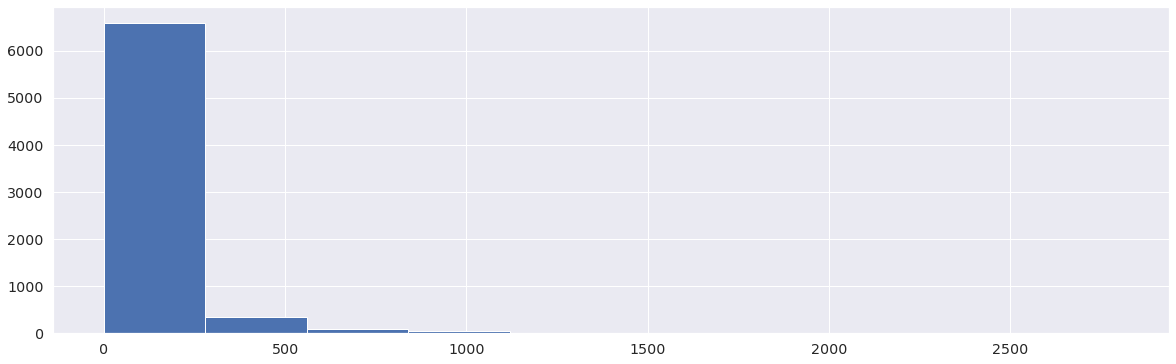

In [ ]:
partial_dataset['Revenue'].hist(figsize=(20,6))

In [ ]:
partial_dataset["Revenue"].describe()

count    7129.000000
mean       83.755906
std       169.351064
min         0.340147
25%         5.555305
50%        23.355100
75%        85.241496
max      2797.800564
Name: Revenue, dtype: float64

In [ ]:
partial_dataset["Revenue_Category"] = pd.cut(partial_dataset["Revenue"],
                                           bins=[0, 6, 23, 85, 300, np.inf],
                                           labels=[1, 2, 3, 4, 5])

print(partial_dataset["Revenue_Category"].value_counts())

1    1866
3    1799
2    1678
4    1295
5     491
Name: Revenue_Category, dtype: int64


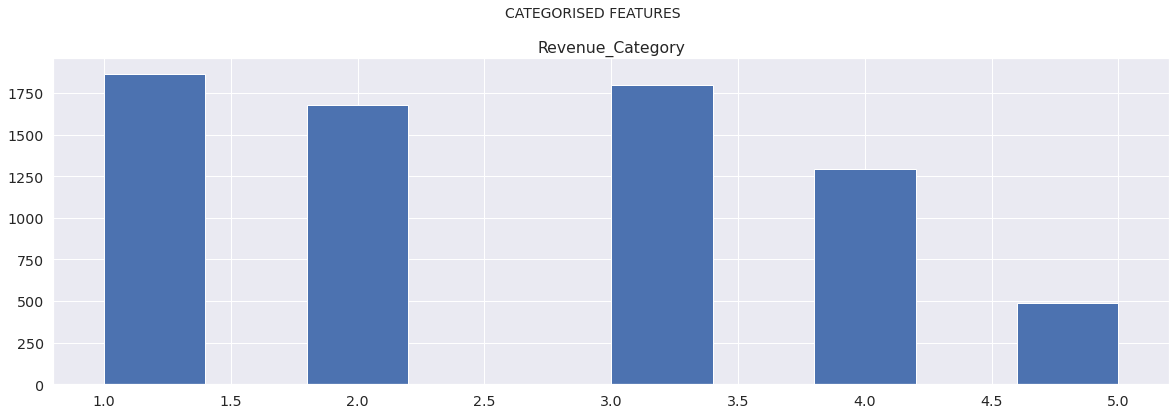

Counts for each categories of the respective features :
-------------------------------------------------------
1    1866
3    1799
2    1678
4    1295
5     491
Name: Revenue_Category, dtype: int64


In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
fig.suptitle('Categorised Features'.upper(), y=1.0, fontsize=14)

# Left histogram
axes.set_title('Revenue_Category')
partial_dataset['Revenue_Category'].hist(ax=axes)

plt.show()

print("Counts for each categories of the respective features :")
print("-------------------------------------------------------")
print(partial_dataset["Revenue_Category"].value_counts())

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split based on the y-label, 'Duration_Category'
for train_index, test_index in split.split(partial_dataset, partial_dataset["Revenue_Category"]):
    strat_train_set = partial_dataset.loc[train_index]
    strat_test_set = partial_dataset.loc[test_index]

# The test set generated using stratified sampling has duration category proportions almost identical to those in the full dataset
# This is to prevent skewed test set that is generated via purely random sampling
print("Stratified Shuffle Split test set :\n", strat_test_set["Revenue_Category"].value_counts() / len(strat_test_set))
print()
print("Original distribution for data set (with respect to selected target) :\n",
      partial_dataset["Revenue_Category"].value_counts() / len(complete_data))

Stratified Shuffle Split test set :
 1    0.261571
3    0.252454
2    0.235624
4    0.181627
5    0.068724
Name: Revenue_Category, dtype: float64

Original distribution for data set (with respect to selected target) :
 1    0.261748
3    0.252350
2    0.235377
4    0.181652
5    0.068874
Name: Revenue_Category, dtype: float64


The returned stratified randomized folds from "StratifiedShuffleSplit" are made by preserving the percentage of samples for each class.

Split stratification is done based on the target, y labels (eg. 'Revenue')

Shows that Stratified sampling is better used to prevent skewed test set that is generated via purely random sampling

### Testing effect on accuracy if removing low correlation features/predictors
**Remove 'Duration', 'Vote_Average', 'Movie_Popularity'**

In [ ]:
#Correlation of all variables with Revenue alone

corr_matrix = complete_data.corr()
corr_matrix["Revenue"].sort_values(ascending=False)

Revenue             1.000000
Vote_Count          0.756105
Budget              0.693358
Actor_Popularity    0.340591
Movie_Popularity    0.191150
Vote_Average        0.170997
Duration            0.131857
Actor_Index         0.076272
Year                0.019889
ID                  0.000912
Name: Revenue, dtype: float64

In [ ]:
X_train

,Movie_Popularity,Duration,Budget,Vote_Average,Vote_Count,Actor_Popularity,PCC_OHE_1,PCC_OHE_2,PCC_OHE_3,PCC_OHE_4,PCC_OHE_5
6078,0.194778,1.119855,-0.223611,1.475483,1.184723,4.836048,0.0,0.0,1.0,0.0,0.0
420,0.066141,0.291841,-0.012173,0.938666,1.855976,0.290254,1.0,0.0,0.0,0.0,0.0
6245,-0.232769,-1.364186,-0.664106,1.475483,-0.563622,-0.424433,0.0,1.0,0.0,0.0,0.0
553,0.021488,-0.623332,-0.247104,-0.242332,1.514100,0.107685,1.0,0.0,0.0,0.0,0.0
1397,-0.118735,-0.274694,0.040686,0.079758,-0.318794,-0.119404,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3772,-0.117153,-0.710491,-0.070201,-0.886513,-0.486791,-0.162271,1.0,0.0,0.0,0.0,0.0
5191,-0.106345,0.596899,-0.223611,0.294485,-0.400404,-0.037921,0.0,0.0,1.0,0.0,0.0
5226,-0.092131,-0.318274,-0.611246,0.723939,-0.295635,2.562324,1.0,0.0,0.0,0.0,0.0
5390,-0.081443,-0.754071,-0.388062,-0.242332,-0.517303,-0.042645,1.0,0.0,0.0,0.0,0.0


In [ ]:
X_train_new = X_train.drop(columns = ['Movie_Popularity', 'Vote_Average', 'Duration'])
X_train_new

,Budget,Vote_Count,Actor_Popularity,PCC_OHE_1,PCC_OHE_2,PCC_OHE_3,PCC_OHE_4,PCC_OHE_5
6078,-0.223611,1.184723,4.836048,0.0,0.0,1.0,0.0,0.0
420,-0.012173,1.855976,0.290254,1.0,0.0,0.0,0.0,0.0
6245,-0.664106,-0.563622,-0.424433,0.0,1.0,0.0,0.0,0.0
553,-0.247104,1.514100,0.107685,1.0,0.0,0.0,0.0,0.0
1397,0.040686,-0.318794,-0.119404,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
3772,-0.070201,-0.486791,-0.162271,1.0,0.0,0.0,0.0,0.0
5191,-0.223611,-0.400404,-0.037921,0.0,0.0,1.0,0.0,0.0
5226,-0.611246,-0.295635,2.562324,1.0,0.0,0.0,0.0,0.0
5390,-0.388062,-0.517303,-0.042645,1.0,0.0,0.0,0.0,0.0


In [ ]:
X_test

,Movie_Popularity,Duration,Budget,Vote_Average,Vote_Count,Actor_Popularity,PCC_OHE_1,PCC_OHE_2,PCC_OHE_3,PCC_OHE_4,PCC_OHE_5
7107,-0.171890,-1.364186,-0.667630,0.187122,-0.545241,-1.109715,1.0,0.0,0.0,0.0,0.0
2177,0.019878,-0.318274,0.622139,-0.027605,-0.098230,0.729080,1.0,0.0,0.0,0.0,0.0
927,0.040046,-0.579752,0.034813,-0.671786,0.049917,-0.207264,0.0,0.0,1.0,0.0,0.0
4332,-0.157984,0.814798,0.175771,-0.027605,-0.536786,-0.193919,1.0,0.0,0.0,0.0,0.0
5312,0.201228,0.379001,-0.364569,1.153393,0.546923,0.030217,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4439,-0.151038,-0.361854,-0.317583,-1.423330,-0.540095,-0.019381,1.0,0.0,0.0,0.0,0.0
3834,-0.085600,-0.579752,-0.364569,-1.423330,-0.482748,0.068951,0.0,0.0,1.0,0.0,0.0
6049,-0.248096,2.688724,-0.641787,-2.389601,-0.567298,-1.038506,0.0,0.0,1.0,0.0,0.0
184,0.379868,-0.187535,0.504674,-0.027605,2.992253,0.854611,1.0,0.0,0.0,0.0,0.0


In [ ]:
X_test_new = X_test.drop(columns = ['Movie_Popularity', 'Vote_Average', 'Duration'])
X_test_new

,Budget,Vote_Count,Actor_Popularity,PCC_OHE_1,PCC_OHE_2,PCC_OHE_3,PCC_OHE_4,PCC_OHE_5
7107,-0.667630,-0.545241,-1.109715,1.0,0.0,0.0,0.0,0.0
2177,0.622139,-0.098230,0.729080,1.0,0.0,0.0,0.0,0.0
927,0.034813,0.049917,-0.207264,0.0,0.0,1.0,0.0,0.0
4332,0.175771,-0.536786,-0.193919,1.0,0.0,0.0,0.0,0.0
5312,-0.364569,0.546923,0.030217,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
4439,-0.317583,-0.540095,-0.019381,1.0,0.0,0.0,0.0,0.0
3834,-0.364569,-0.482748,0.068951,0.0,0.0,1.0,0.0,0.0
6049,-0.641787,-0.567298,-1.038506,0.0,0.0,1.0,0.0,0.0
184,0.504674,2.992253,0.854611,1.0,0.0,0.0,0.0,0.0


**Tuned Linear Regression Scores**

RMSE: 93.57

**Actually worst after removal of low correlation features/predictors**

In [ ]:
grid_search_LinearReg.fit(X_train_new, y_train)

# Using tuned linear reg for predictions for new data
final_model_LinearReg = grid_search_LinearReg.best_estimator_


final_test_LinearReg_pred = final_model_LinearReg.predict(X_test_new) #(test set)

final_mse_LinearReg = mean_squared_error(y_test, final_test_LinearReg_pred) # y_test
final_rmse_LinearReg = np.sqrt(final_mse_LinearReg)

print("Linear Regression:\n")
print("root mean squared error of test is: ", final_rmse_LinearReg)

Linear Regression:

root mean squared error of test is:  93.57917962181239


**Tuned Decision Tree Scores**

RMSE of test: 115.43

**Worst after removal of low correlation features/predictors**

In [ ]:
param_grid = [
              { 'criterion': ['mse', 'friedman_mse', 'mae'],
                'splitter': ['best','random'],
                'max_depth': [2,4,6,8,10,12],
                'max_features': [2, 4, 6, 8]
              }
  ]

tree_reg = DecisionTreeRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search_DecisionTree = GridSearchCV(tree_reg, param_grid, cv=10, # 5
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search_DecisionTree.fit(X_train_new, y_train)

# Using tuned Decision Tree for predictions for new data
final_model_DecisionTree = grid_search_DecisionTree.best_estimator_


final_test_DecisionTree_pred = final_model_DecisionTree.predict(X_test_new) #(test set)

final_mse_DecisionTree = mean_squared_error(y_test, final_test_DecisionTree_pred) # y_test
final_rmse_DecisionTree = np.sqrt(final_mse_DecisionTree)


In [ ]:
print("Decision Tree: \n")
print("root mean squared error of test is: ", final_rmse_DecisionTree)

Decision Tree: 

root mean squared error of test is:  115.43948397370261


**Tuned Random Forest Regressor Scores**

RMSE of test: 92.41

**Performs worst after removal as Random Forest does splits based on independent variables hence the more independent the variables the better the accuracy**

In [ ]:
param_grid = [
    # combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 
     'max_features': [2, 4, 6, 8], 
     'bootstrap': [True,False]
     }, 
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search_RandomForest = GridSearchCV(forest_reg, param_grid, cv=10, # 5
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search_RandomForest.fit(X_train_new, y_train)

# Using tuned Random Forest model for predictions for new data
final_model_RandomForest = grid_search_RandomForest.best_estimator_


final_test_RandomForest_pred = final_model_RandomForest.predict(X_test_new) #(test set)

final_mse_RandomForest = mean_squared_error(y_test, final_test_RandomForest_pred) # y_test
final_rmse_RandomForest = np.sqrt(final_mse_RandomForest)


In [ ]:
print("Random Forest: \n")
print("root mean squared error is: ", final_rmse_RandomForest)

Random Forest: 

root mean squared error is:  92.41381361499714
